# <font size="6"><b>Preliminaries</b></font> 

<font size="5"><b>Study Summary</b></font>  

<font size="4"> 
    BOLD signals from the human brain are known to exhibit a single whole-brain quasiperiodic pattern (QPP). What is less known is how this  pattern relates to the plethora of other spatial and temporal patterns observed in resting-state BOLD signals. In this study, we demonstrate that many previously observed resting-state fMRI results are complementary descriptions of the static and time-lagged dynamics of the QPP. For static or zero-lag correlation, the top eigenvector or principal component of zero-lag covariance relationships among whole-brain BOLD signals is a static description of QPP dynamics. Further, the second top eigenvector resembles the task-positive and task-negative pattern, and/or the primary functional connectivity gradient. We demonstrate that the second eigenvector arises due to the geometric constraints of eigenvector solutions or global signal regression, and describes the same dynamics as the first top eigenvector. These findings are generalized to manifold-learning algorithms, such as Laplacian Eigenmaps, that are popular algorithms for deriving functional connectivity gradients. Seed-based correlation analyses exhibt a similar pattern of results to the eigendecomposition solution. Low-dimensional functional connectivity parcellations are also shown to be predicatably related to the dynamics of the QPP. Analagous to the results for zero-lag correlations, we find that the eigendecomposition of time-lagged correlation matrices yields the QPP as the dominant mode of variablity. Lag projection analysis returns similar spatiotemporal patterns to the top eigenvector of the time-lagged covariance matrix. Overall, we find that the QPP underlies a striking variety of previously observed phenomena in resting-state BOLD signals within the frequency range of 0.01 to 0.1 Hz. We discuss the need for resting-state fMRI research to turn its attention towards explaining the physiological and neural components of the QPP.
</font>

<font size="5"><b>Study Outline</b></font>  
<font size="4"> <b>1. The Resting State Quasiperiodic Pattern</b></font>  
* Description: Computation of the QPP using the original algorithm of Keilholz and colleagues, and visual illustration of the spatiotemporal patterns of the QPP   

<font size="4"> <b>2. Eigendecomposition and the QPP</b></font>  
* Description: Detailed analysis of eigendecomposition in resting-state fMRI signals. Eigendecomposition applied to a whole-brain voxel-by-voxel similarity matrix yields the dominant dimensions of variability among whole-brain voxel BOLD signals.  We describe the various eigendecomposition analyses popular in resting-state fMRI research and visualize their results when applied to resting-state whole-brain BOLD signals. Some of these analyses, such as Laplacian Eigenmaps, are popular manifold learning algorithms for the computation of functional connectivity gradients. We demonstrate that these popular eigendecomposition analyses yield one of two patterns as the most dominant mode of variability: a globally positive component or a task-positive/task-negative component. Surprisingly, traditional seed-based correlation analyses with global signal regression are shown to return almost identical correlation patterns to eigendecompostion results. We show that these two dominant modes of variability are mathematically-orthogonal descriptions of the *same* BOLD covariance pattern. *Most importantly, we show that the time series of this single dominant mode of variability closely follows the time series of the QPP*. 

<font size="4"> <b>3. The Spatiotemporal Dynamics of the QPP</b></font>
* Description: Eigendecomposition and seed-based correlation analysis of zero-lag correlation analyses can only capture static covariance patterns. We show that when one averages around the peaks of the time series of the dominant mode of variability (described in *Sec 2*), a spatiotemporal pattern is observed that almost precisely matches the spatiotemporal dynamics of the QPP. This observation led us to test the hypothesis that the QPP is dominant mode of variability among *time-lagged correlations* of whole-brain BOLD signals. According to this hypothesis, eigendecomposition of time-lagged covariance relationships matrices should reliably yield the QPP as the top eigenvector/principal component. We demonstrate this is indeed the case. Using two extensions of eigendecomposition analysis designed to capture spatiotemporal signals, the top eigenvector of time-lagged covariance matrices resembles the QPP. A similar analysis for analyzing spatiotemporal signals, lag projection analysis, returns similar findings to the top eigenvector of the time-lagged covariance matrix.


## Module Imports

In [217]:
import ipyplot
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nibabel as nb
import numpy as np
import pickle

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from numpy import random as rand
from scipy import linalg
from scipy.signal import resample
from scipy.stats import zscore
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import MDS, Isomap
from sklearn.metrics import pairwise_distances
from utils.utils import load_data_and_stack, load_gifti, pull_gifti_data, load_cifti, pull_cifti_data, \
write_to_gifti, double_gamma_hrf, convolve_hrf_events


## Helper Functions

In [218]:
def create_hrf_group(n_ts, activation_indx, ts_len, tr, amplitude, phase_jitter, 
                     amplitude_jitter, ts_sampling=0.01, repeat_n=1):
    """
    n_ts: number of timeseries
    activation_indx = index of activation time point
    ts_len: length of time series
    tr: the sampling rate of the original time series
    amplitude: amplitude of double gamma function 
    phase_offset_window: allowable phase offsets between time series - 
        set as a symmetric window length - sampled from uniform distribution
    ts_sampling: resolution of original time series - default=0.01 Hz
    std_noise: amount of gaussian noise to add to time series - scaling parameter between 0 and 1
    """
    hrf=double_gamma_hrf(60, ts_sampling)
    ts_all = np.zeros((n_ts, ts_len))
    for n in range(n_ts):
        ts = ts_all[n,:]
        indx = rand.randint(activation_indx - phase_jitter, 
                          activation_indx + phase_jitter)
        amp = rand.randint(amplitude - amplitude_jitter, 
                           amplitude + amplitude_jitter)
        ts[indx] = 1
        ts_all[n,:] = (convolve_hrf_events(hrf, ts) * amplitude)
    n_resample=np.int(ts_sampling*ts_len/tr)
    hrf_ts_resample = resample(ts_all, n_resample, axis=1)
    return np.tile(hrf_ts_resample, repeat_n)


def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.1)

    
def transition_matrix(transitions):
    #https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
    n = 1 + np.int(np.nanmax(transitions)) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        if ~np.isnan(i) and ~np.isnan(j):
            M[np.int(i)][np.int(j)] += 1
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)


def xcorr(x, y, maxlags=30):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')
    c = np.correlate(x, y, mode=2)
    c /= np.sqrt(np.dot(x, x) * np.dot(y, y))
    if maxlags is None:
        maxlags = Nx - 1
    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)
    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    max_r = c[np.argsort(np.abs(c))[-1]]
    max_lag = lags[np.argsort(np.abs(c))[-1]]
    return max_r, max_lag


# <b>1. The Resting-State Quasiperiodic Pattern</b>

<font size ='4'>Keilholz et al. (2011; 2014; 2018) have rigorously described a spatiotemporally extended BOLD pattern, they term a quasiperiodic pattern (QPP), that occurs regularly (or quasiperiodically) in human resting-state fMRI BOLD signals. A similar large-scale pattern can be observed in rats (Majeed et al., 2011). QPPs are conventionally detected use an autoregressive template matching procedure that operates in the following manner: start with a random window of BOLD TRs, compute a sliding window correlation of the window across the entire scan at each time point, and then average this segment with similar segments of BOLD TRs (defined using a correlation threshold). This process is done iteratively until a level of convergence is reached. The result is a spatiotemporal averaged template of BOLD dynamics (that could be displayed in a movie, for example). In a series of papers (Majeed et al. 2011; Thompson et al. 2014; Yousefi et al. 2018), Keilholz and colleagues have found that this method reliably detects a large-scale periodic BOLD pattern in humans and rats. We took a sample of 50 subjects from the Human Connectome Project (HCP) and conducted the same QPP algorithm on our data. We visualize the QPP below (shown in a movie):</font>

In [9]:
%%HTML
<header>
    <h4>Quasiperiodic Pattern (QPP)</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/qpp_rest.mp4"
        type="video/mp4">                                                       
</video>

<font size='4'>The QPP has a bipolar pattern. It begins with peak positive amplitudes in the sensorimotor, superior parietal, superior temporal and lateral visual cortices. Simultaneous with these peaks are strong negative amplitudes in the inferior parietal cortex, precuneus and posterior medial frontal cortex. These regions make up the Default Mode Network (DMN). The peak positive amplitudes in the sensorimotor and superior parietal cortex propagate in two broad directions: downwards to the primary visual cortex, inferior parietal cortex, and Precuneus; forward to the lateral prefrontal cortex and posterior medial frontal cortex. In other words, the QPP ends with peak amplitudes of the DMN and primary visual cortex.</font>

# <b>2. Extracting the QPP from Time-Lag Analysis of Resting-State BOLD Signals</b>

<font size='4'>The autoregressive template matching technique of Keilholz et al. is sensitive to the choice of the random window in the beginning of the alogrithm. Yousefi et al. (2018) use an exhaustive search through all possible starting points for the window and take the window with the highest summed correlation across the scan. There are no theoretical gurantees that the same pattern will be derived from different random starting points. However, Yousefi et al. (2018) has demonstrated that the QPP pattern is reliably associated with the random starting point with the highest correlation across the length of the scan (or multiple scans, in the case of concatenated data). This an empirical property of the QPP, as opposed to a feature of the algorithm. In other words, the QPP is such a predominant pattern in whole-brain BOLD time series, searching for that segment of multivariate BOLD time series that is maximally correlated with all other segments predictably returns the QPP pattern in that window.</font>

<font size='4'> If the QPP is <i>the</i> predominant spatiotemporal pattern in resting-state whole-brain BOLD signals, the spatiotemporal dynamics of the QPP should be reflected in time-lagged correlations between cortical time series. We distinguish time-lagged correlations from zero-lag correlations: time-lagged correlations reflect the Pearson correlation between cortical time series at different shifts in time (lagged forward or backwards), while zero-order correlations reflect the Pearson correlation between the non-shifted/lagged signals. Time-lag analysis is capable of capturing propagating or travelling wave BOLD signals, similar to that observed above in the QPP. Zero-order analysis is only capable of capturing in-phase or out-of-phase relationships between BOLD signals. </font>

<font size='4'> We introduce two time-lag analysis approaches capable of capturing propagating phenomena. These approaches are known as Complex Hilbert Empirical Orthogonal Functions (CHEOF) and Extended Empirical Orthogonal Functions (EEOF). Both are eigendecomposition techniques regularly used in the fields of Atmospheric and Climate sciences to capture spatiotemporal patterns in meteorological fields. <b>Eigendecomposition techniques</b> are well-suited for extracting the sort of 'global' whole-brain patterns observed in the QPP. In the case of a symmetric matrix, eigendecomposition techniques decompose the matrix into an orthogonal set of basis vectors, known as eigenvectors, and associated scaling values, known as eigenvalues. Eigendecomposition applied to a covariance/correlation matrix is known as principal component analysis (PCA). The top N eigenvectors (and associated eigenvalues) or principal components of a covariance matrix represent the top N dimensions of variability in the data. This property of PCA makes it a popular tool for dimension reduction. In our case, it has a further utility: a re-occuring global spatiotemporal event that involves the majority of cortical bold time series should/might be reflected in one of the top principal components of the vertex-by-vertex correlation matrix. In the Atmospheric and Climate Sciences, eigendecomposition analysis applied to static covariance/correlation matrices is commonly referred to as empirical orthogonal function (EOF) analysis (as opposed to PCA). However, standard EOF analysis fails to capture the propagating and travelling wave behavior characteristic of metereological fields. CHEOF and EEOF (somtimes referred to as Multivariate Singular Spectrum Analysis; MSSA) are extensions of EOF to fields composed of propagating waves.</font>


## 2.1 Complex Hilbert Empirical Orthogonal Functions

<font size="4"> CHEOF is simply an extension of PCA applied to complex signals derived from the Hilbert transform. The Hilbert transform of a signal is the original signal phase shifted by $\pi/2$. The original signal composed with its hilbert transformed signal is known as the analytic signal. The analytic signal is a complex vector with real and imaginary components. The analytic signal allows us to define the instaneous amplitude envelope and phase of the signal at any point in time. In CHEOF, eigendecomposition is applied to the complex cross-correlation matrix derived from a set of analytic signals, and results in complex eigenvectors/principal components. In the same manner the complex (analytic) signal can be expressed in terms of imaginary and real components, the complex principal components can be expressed in real and imaginary components. The real component weights corresponds to the spatial weights of the original signal (no phase delay), while the imaginary component corresponds to the spatial weights of the delayed signals phase shifted by $\pi/2$. More importantly, in the same manner we can express a complex number in terms of amplitude and phase components, the complex components can be represented in the form of a spatial phase delay map - giving information on the relative phase between the peak amplitudes of the cortical BOLD time series. THE CHEOF was applied to the same resting-data above (note, this data was band-pass filtered in the preprocessing to the conventional resting-state fMRI frequency range: 0.01 - 0.1Hz). The first principal component real, imaginary and phase delay maps are displayed below: </font>  

In [3]:
ipyplot.plot_images(['demo_files/pca_rest_complex_comp0_real.png',
                     'demo_files/pca_rest_complex_comp0_imag.png',
                     'demo_files/pca_rest_complex_comp0_ang.png'], 
                    ['Principal Component 1 - Real Component', 
                     'Principal Component 1 - Imaginary Component',
                     'Principal Component 1 - Phase Delay'], img_width=500)

<font size="4"> **Real and Imaginary Component maps**: this is read similarly to principal component maps from conventional PCA, except that the imaginary component is the spatial pattern of the principal component shifted foward in time by $\pi/2$. The spatial pattern of the real component seems to precisely match the beginning phase of the QPP. The imaginary component seems to correspond to the latter end of the QPP - where the BOLD signals of the DMN and primary visual cortex are decaying.  </font>

<font size="4"> **Phase delay map**: The phase delay map is read backwards: it is the phase difference between the vertex BOLD signal and the principal component time series - i.e. BOLD signals with maximum correlation at a later time than the principal component time series is at a negative phase shift, and signals with maximum correlaton at an earlier time is a positive phase shift. Reading our phase delay map backwards then: the principal component peaks earlier in the sensorimotor cortex, superior temporal gyrus and lateral visual cortex and then propagates towards regions of the DMN. Notice how much the two 'ends' of this spatiotemporal pattern - early sensiormotor/superior parietal/superior temporal vs. late DMN - precisely match the dynamics of the QPP.</font>

## 2.2 Extended Empirical Orthogonal Functions

<font size='4'> The results of the CHEOF analysis demonstrate the propagation behavior of the QPP can be captured by eigendecomposition of a modified correlation matrix. However, the CHEOF analysis does not fully describe the spatiotemporal pattern of the QPP - it does not allow for *time-varying spatial weights* that express changing amplitudes of BOLD signals across time. Extended Empirical Orthgonal Functions (EEOF) is an alternative extension of PCA for capturing propagating or travelling wave behavior. This analysis is also known as Multivariate Singular Spectrum anlaysis (MSSA) in the dynamical systems literature. The principal component weights returned by EEOFs vary over time in a fixed window ($w$). The first step of the EEOF analysis is the creation of a time-delay embedding matrix: for each vertex BOLD signal, lag-N shifted copies are created (lag-1, lag-2, etc., all the way up to the window length $w$) and treated as separate variables in the columns of the matrix. Eigendecomposition of the time-delay embedding covariance matrix returns spatiotemporally extended eigenvectors: with weights for each time point up to the window length $w$. We chose a window length of 30 TRs (21 secs), corresponding to the estimated length of the QPP by Keilholz and colleagues. A benefit of EEOF analysis is its ability to capture oscillatory patterns in time series in the form of paired eigenvectors (Groth and Ghil, 2011 - Physical Review E). Eigenvector pairs take the form of two phase-offset eigenvectors with identical temporal frequency (analagous to a sine and cosine pair). Thus, given the description of the QPP as a *quasiperiodic* pattern, we might expect the QPP to be represented by the *first two eigenvectors* of the time-delay embedding covariance matrix. We find that this is indeed the case for our data. We display the temporally extended weights of the first two eigenvectors or principal compnents of the time-delay embedding matrix below (as a movie):

In [100]:
%%HTML

<header>
    <h4>First Principal Component</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/mssa_rest_component0_w50.mp4"
        type="video/mp4">                                                       
</video>
<header>
    <h4>Second Principal Component</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/mssa_rest_component1_w50.mp4"
        type="video/mp4">                                                       
</video>

<font size='4'> Visual observation of the two principal component movies reveals they precisely match the temporal dynamics of the QPP. The first two principal components correspond to oscillatory pairs of the QPP. Further, they exhibit the same propagation or time-lag BOLD patterns in the phase delay map of the first principal component of the CHEOF analysis. As opposed to the CHEOF analysis, the EEOF components have spatial weights that are allowed to vary across time. Thus, the components of the EEOF analysis precisely follows the temporally extended BOLD patterns output by the original QPP algorithm. Both the CHEOF and EEOF analysis reveals that the QPP represents the dominant mode of variabilty in time-lagged covariance matrices.</font>

## 2.3 Lag Projection Analysis
<font size='4'> Time-lagged relationships among whole-brain BOLD signals have been previously described by Mitra et al. (2014; 2015). Mitra and colleagues introduced the concept of lag projections and lag threads (and associated analytic techniques) that capture large-scale temporally-lagged BOLD events in fMRI time series. In other words, lag projections capture BOLD patterns that are temporally extended over time. Mitra et al. (2014) use a parabolic interpolation of lagged cross-covariance functions to identify the time-lag between all pairs of vertices. This results in an anti-symmetric time-delay matrix, which can be used for further analysis. In Mitra et al. (2014) and Raut et al. (2019), a column average of the time-delay matrix yields lag projections - i.e. the average temporal ordering of each vertices peak amplitudes. Lag projections describe the average time-lagged relationships among whole-brain signals and is analagous to the phase-delay map from the CHEOF analysis. We applied the same lag projection analysis to our data and display the results below (along with the phase delay map of the first principal component from the CHEOF analysis): </font>

In [5]:
ipyplot.plot_images(['demo_files/lag_projection.png', 'demo_files/pca_rest_complex_comp0_ang.png'], 
                    ['Lag Projection', 'Principal Component 1 - Phase Delay'], img_width=500)

<font size='4'>The colors in the lag projection maps represent the time delay (in TRs - 0.72s) in peak amplitudes between vertex time series. It is read left to right: from early regions in green/cool colors, to positive regions in light/red colors. The lag-projection follows precisely the pattern observed in the above analyses:(<b>Sec. 3.1</b>): peak amplitudes begin in the sensorimotor cortices and (slightly later) in lateral/medial visual cortices, followed later by DMN and primary visual cortex peak amplitudes. This exactly matches the temporal dynamics of the first CHEOF principal component represented by the phase delay map (read backwards).  Note, these lag projections only partially resemble the across-subject average lag projection in Raut et al. (2019) - the differences are due to global signal regression, which we discuss in <b>Appendix B</b> </font> 

## 3.4 Summary of Time-lag Analyses

<font size='4'> Despite the fundamentally different algorithms, all approaches converge on one spatiotemporal pattern - peak amplitudes in the sensorimotor cortex, superior temporal gyrus and lateral visual cortex, followed by peak amplitudes in the DMN and primary visual cortex. In other words, lag-projection anlaysis, eigendecomposition of time-lagged correlations, and the auto-regressive template matching approach all return the QPP. The replication of the QPP across these disparate approaches attests to the dominance of this spatiotemporal pattern in resting-state BOLD signals

# <b>2. Zero-Lag Analysis of Resting-State BOLD Signals</b>

<font size='4'> The majority of studies in resting-state fMRI in the literature analyze zero-lag relationships among BOLD signals (or higher-order zero-lag statistics). A primary aim of this study is to relate the spatiotemporal pattern of the QPP to the output of zero-lag analyses in resting-state BOLD signals. We attempt to show that the output of popular zero-lag analyses are static descriptions of the QPP spatiotemporal pattern. Specifically, we demonstrate that 1) most zero-lag analyses return the same set of spatial and temporal patterns, and 2) that set of patterns describe a single spatiotemporal event - the QPP. </font>

## 2.1 Survey of Zero-Lag Resting-State Analyses

<font size='4'> One difficulty is the sheer variety of zero-lag analyses: seed-based correlation analysis, functional connectivity gradients (manifold learning), co-activation pattern analysis, independent component analysis, and eigendecomposition analyses (e.g. PCA). Further, the output of these analyses have been associated with a striking variety of physical interpretations: the task-positive/task-negative(TP/TN) network, the global signal, functional connectivity connectomes, information processing gradients, spatial point processes, and spatially independent networks or temporally independent modes. We applied some of the more popular zero-lag analyses to the same HCP data used above. Importantly, we show that all of these analyses return similar sets of spatial and temporal patterns. Further, we show that differences between their output can be attributed to frame-by-frame intensity normalization or global signal regression. The zero-lag anlayses conducted include:
</font>  
<ol>    
    <font size='4'><li>Principal Component Analysis (with and without time point mean-centering)</li>
    <li>Laplacian Eigenmaps</li>
        <ul>
            <li>Laplacian Eigenmaps is a popular nonlinear manifold learning algorithm used in the study of functional connectivity gradients</li>
        </ul>
    <li>Seed-Based Correlation Analysis (with and without global signal regression)</li>
        <ul>
            <li>Two bilateral seeds placed in: Precuneus and Somatosensory Cortex</li>
        </ul>
    <li>PCA w/ Simple Structure Rotation</li>
    <li>Spatial and Temporal ICA.</li>    
    <li>Whole-Brain CAPS Analysis (with and without time point normalization)</li>
        <ul>
            <li>Two bilateral seeds placed in: Precuneus and Somatosensory Cortex</li>
        </ul>
    </font>
</ol>

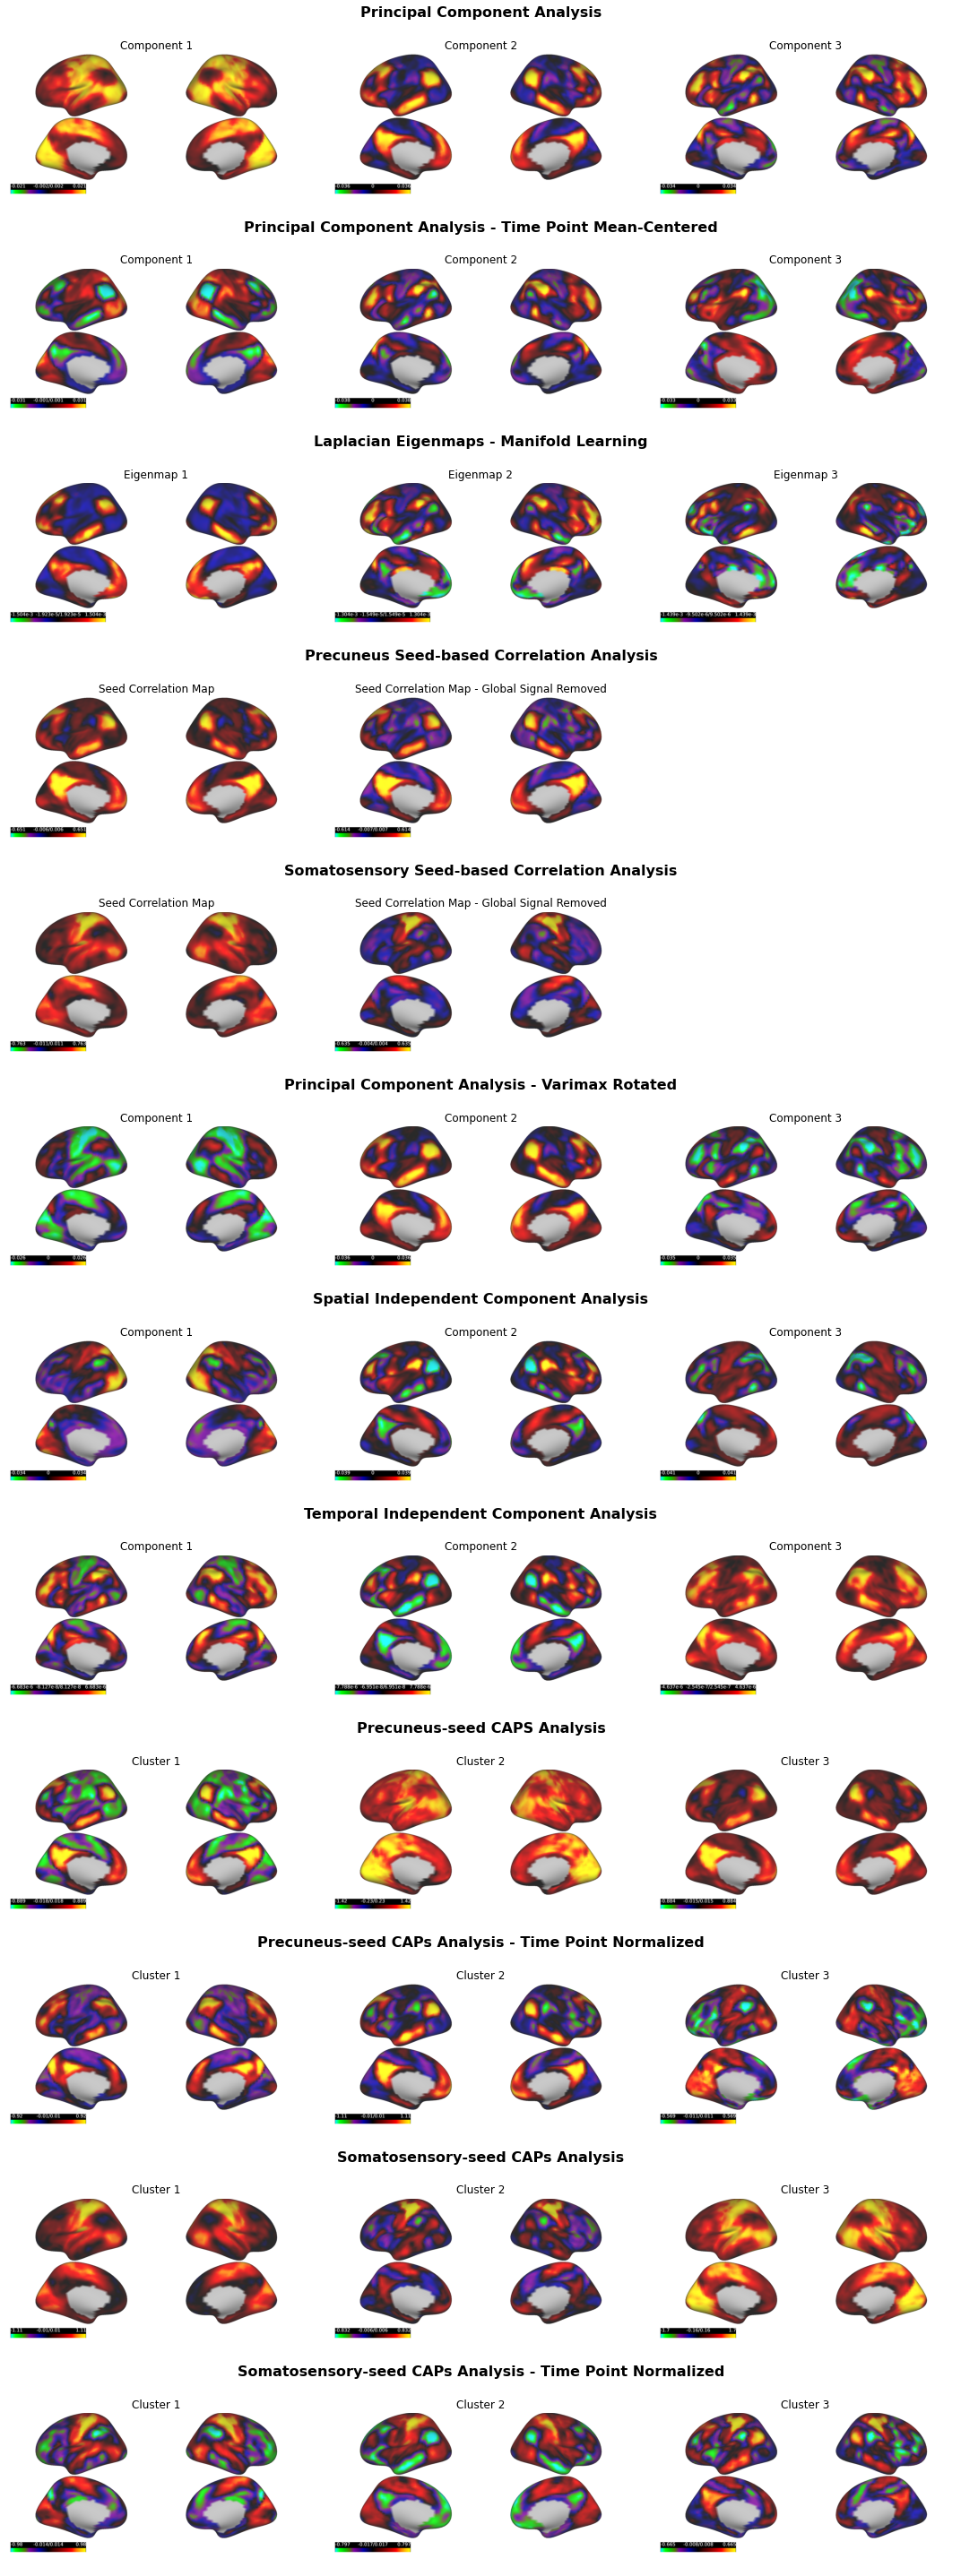

In [38]:
fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'],
       ['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png'],
       ['demo_files/diffusion_emb_comp0.png', 'demo_files/diffusion_emb_comp1.png', 'demo_files/diffusion_emb_comp2.png'], 
       ['demo_files/fc_map_precuneus.png', 'demo_files/fc_map_precuneus_gs.png'], 
       ['demo_files/fc_map_sm.png', 'demo_files/fc_map_sm_gs.png'], 
       ['demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 
        'demo_files/pca_rest_varimax_comp2.png'], 
       ['demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 'demo_files/spatial_ica_comp2.png'], 
       ['demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 'demo_files/temporal_ica_comp2.png'], 
       ['demo_files/caps_precuneus_cluster0.png', 'demo_files/caps_precuneus_cluster1.png', 
        'demo_files/caps_precuneus_cluster2.png'],
       ['demo_files/caps_precuneus_norm_cluster0.png', 'demo_files/caps_precuneus_norm_cluster1.png', 
       'demo_files/caps_precuneus_norm_cluster2.png'], 
       ['demo_files/caps_sm_cluster0.png', 
       'demo_files/caps_sm_cluster1.png', 'demo_files/caps_sm_cluster2.png'],
       ['demo_files/caps_sm_norm_cluster0.png', 'demo_files/caps_sm_norm_cluster1.png', 
       'demo_files/caps_sm_norm_cluster2.png']]
labels = [['Component 1', 'Component 2', 'Component 3'],
          ['Component 1', 'Component 2', 'Component 3'],
          ['Eigenmap 1', 'Eigenmap 2', 'Eigenmap 3'], 
          ['Seed Correlation Map', 'Seed Correlation Map - Global Signal Removed'],
          ['Seed Correlation Map', 'Seed Correlation Map - Global Signal Removed'],
          ['Component 1', 'Component 2', 'Component 3'], 
          ['Component 1', 'Component 2', 'Component 3'], 
          ['Component 1', 'Component 2', 'Component 3'],
          ['Cluster 1', 'Cluster 2', 'Cluster 3'],
          ['Cluster 1', 'Cluster 2', 'Cluster 3'],
          ['Cluster 1', 'Cluster 2', 'Cluster 3'],
          ['Cluster 1', 'Cluster 2', 'Cluster 3']]
section_labels = ['Principal Component Analysis', 'Principal Component Analysis - Time Point Mean-Centered', 
                  'Laplacian Eigenmaps - Manifold Learning',
                  'Precuneus Seed-based Correlation Analysis', 'Somatosensory Seed-based Correlation Analysis', 
                  'Principal Component Analysis - Varimax Rotated', 'Spatial Independent Component Analysis', 
                  'Temporal Independent Component Analysis', 'Precuneus-seed CAPS Analysis', 
                  'Precuneus-seed CAPs Analysis - Time Point Normalized', 
                  'Somatosensory-seed CAPs Analysis', 'Somatosensory-seed CAPs Analysis - Time Point Normalized']
fig, big_axes = plt.subplots(figsize=(15, 40) , nrows=12, ncols=1, sharey=True) 

for row, (big_ax, section_labels) in enumerate(zip(big_axes, section_labels), start=1):
    big_ax.set_title(f"{section_labels}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')
indx = 0
for i, (fp_sec, label_sec) in enumerate(zip(fps, labels)):
    for j in range(3):
        indx += 1
        ax00 = fig.add_subplot(12, 3, indx)
        if j <= (len(fp_sec) - 1):
            img = mpimg.imread(fp_sec[j])
            ax00.set_title(label_sec[j])
            ax00.imshow(img)
        ax00.axis('off')

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

<font size='4'> The spatial maps returned by popular zero-lag correlation analyses exhibit striking similarity. The following general observations can be made (further elaborated on below):</font>
<ol>    
    <font size='4'>
    <li> Interestingly, the contrast of spatial weights within each spatial map exhibit a striking correspondence to the two 'ends' of the QPP: sensorimotor, lateral visual, and superior temporal gyrus vs. the DMN. </li>
    <li>All- or close-to-all-positive and -negative maps appear across several analyses, particularly those without global signal regression, or time-point normalization or demeaning (i.e. frame-by-frame intensity normalization).</li>
    <li>A bipolar positive and negative pattern is returned by almost all analyses. This bipolar pattern has different names dependening on the analysis approach used to derive it - the task-positive/task-negative (TP/TN) pattern or network, or the primary functional connectivity gradient. </li>
    <li>A multipolar pattern of positive and negative weights similar in spatial distribution to the bipolar positive and negative pattern. See for example, 'Component 3' from the PCA, and 'Component 2' from the Laplacian Eigenmaps.</li>
    <li>Despite the striking similarity of spatial maps returned by these analyses, the results of each analysis are often given different physical interpretations: global signal, task-positive/task-negative network, connectivity gradients, discrete point processes, etc.</li>
    <li>Some of the results of these analyses depend on the number of components/cluster estimated. For example, both ICA and PCA-rotation method outputs will change depending on the number of components estimated. The more components, the finer the distinctions. Given we are interested in coarse, global patterns such as the QPP, we keep the number of components estimated at a minimum. Non-rotated eigendecomposition analyses, such as PCA and Laplacian Eigenmaps, do not have a dependence on component number. Nor is this obviously the case with seed-based correlation analyses.</li>
</font>
</ol>


## 2.2 Zero-Lag Analysis as 'Snapshots' of the QPP

<font size='4'> Visual observation of the spatial maps produced from popular zero-lag analyses reveals a strong correspondence in the spatial patterns between these maps.

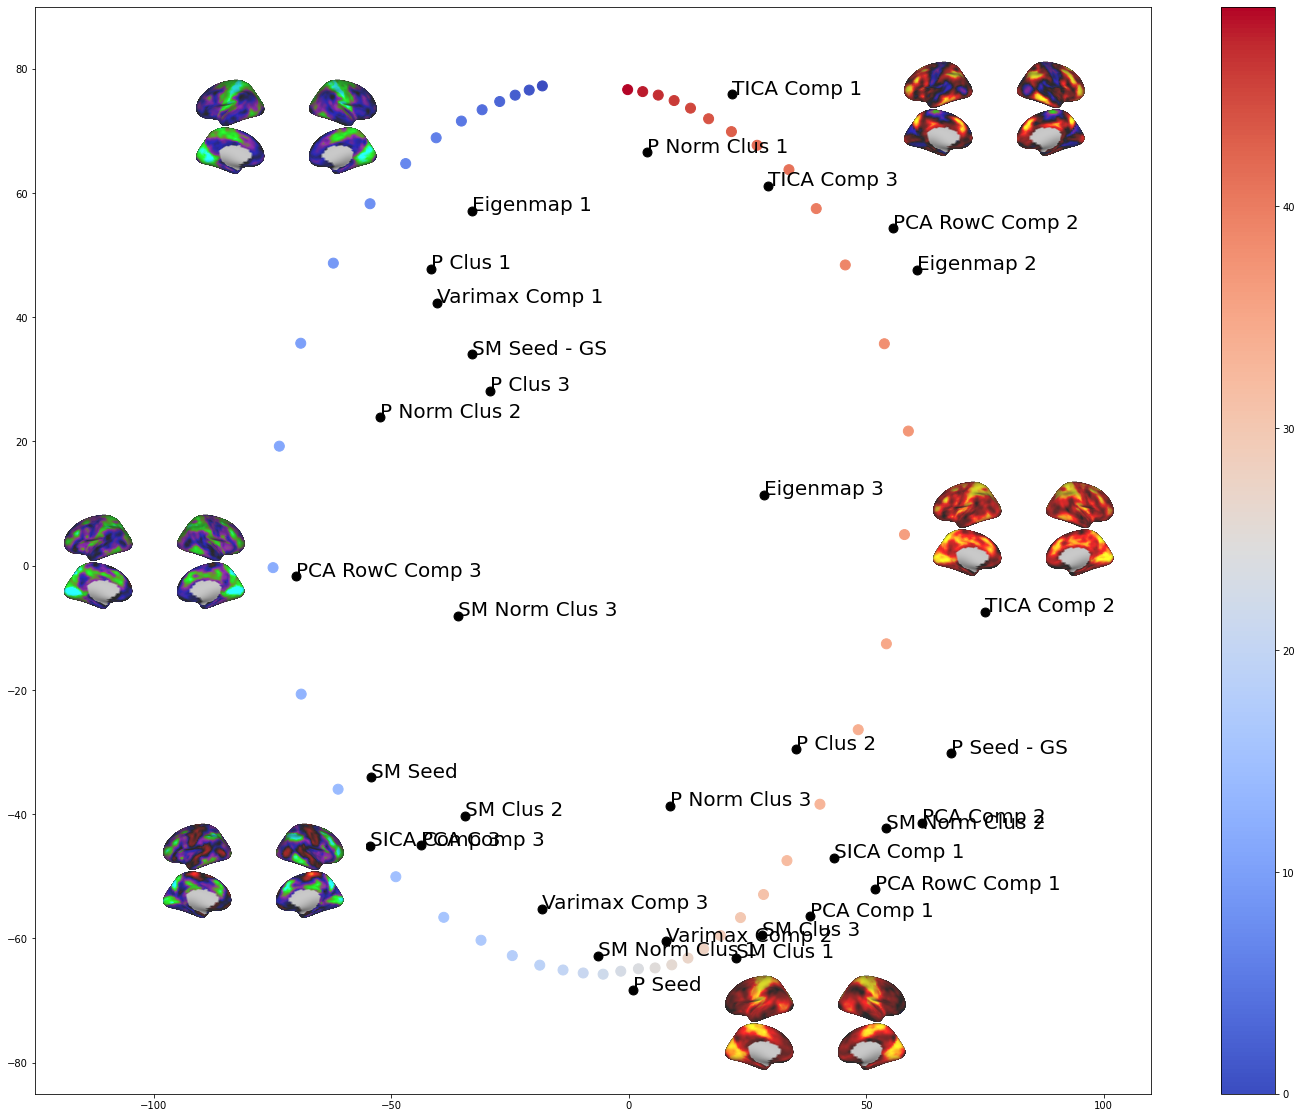

In [223]:
cifti_fps = ['demo_files/pca_rest.dtseries.nii', 'demo_files/pca_tmode_rest.dtseries.nii', 
       'demo_files/diffusion_embedding.dtseries.nii', 'demo_files/pca_rest_varimax.dtseries.nii',
       'demo_files/fc_map_precuneus.dtseries.nii', 'demo_files/fc_map_gs_precuneus.dtseries.nii',
       'demo_files/fc_map_sm.dtseries.nii', 'demo_files/fc_map_gs_sm.dtseries.nii', 
       'demo_files/s_ica.dtseries.nii', 'demo_files/t_ica.dtseries.nii', 
       'demo_files/caps_precuneus.dtseries.nii', 'demo_files/caps_precuneus_norm.dtseries.nii',
       'demo_files/caps_sm.dtseries.nii', 'demo_files/caps_sm_norm.dtseries.nii']
fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'],
       ['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png'],
       ['demo_files/diffusion_emb_comp0.png', 'demo_files/diffusion_emb_comp1.png', 'demo_files/diffusion_emb_comp2.png'], 
       ['demo_files/fc_map_precuneus.png', 'demo_files/fc_map_precuneus_gs.png'], 
       ['demo_files/fc_map_sm.png', 'demo_files/fc_map_sm_gs.png'], 
       ['demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 
        'demo_files/pca_rest_varimax_comp2.png'], 
       ['demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 'demo_files/spatial_ica_comp2.png'], 
       ['demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 'demo_files/temporal_ica_comp2.png'], 
       ['demo_files/caps_precuneus_cluster0.png', 'demo_files/caps_precuneus_cluster1.png', 
        'demo_files/caps_precuneus_cluster2.png'],
       ['demo_files/caps_precuneus_norm_cluster0.png', 'demo_files/caps_precuneus_norm_cluster1.png', 
       'demo_files/caps_precuneus_norm_cluster2.png'], 
       ['demo_files/caps_sm_cluster0.png', 
       'demo_files/caps_sm_cluster1.png', 'demo_files/caps_sm_cluster2.png'],
       ['demo_files/caps_sm_norm_cluster0.png', 'demo_files/caps_sm_norm_cluster1.png', 
       'demo_files/caps_sm_norm_cluster2.png']]
labels = [['PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3'],
          ['PCA RowC Comp 1', 'PCA RowC Comp 2', 'PCA RowC Comp 3'],
          ['Eigenmap 1', 'Eigenmap 2', 'Eigenmap 3'], 
          ['P Seed', 'P Seed - GS'],
          ['SM Seed', 'SM Seed - GS'],
          ['Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3'], 
          ['SICA Comp 1', 'SICA Comp 2', 'SICA Comp 3'], 
          ['TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3'],
          ['P Clus 1', 'P Clus 2', 'P Clus 3'],
          ['P Norm Clus 1', 'P Norm Clus 2', 'P Norm Clus 3'],
          ['SM Clus 1', 'SM Clus 2', 'SM Clus 3'],
          ['SM Norm Clus 1', 'SM Norm Clus 2', 'SM Norm Clus 3']]

cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    cifti_maps_all.append(cifti_maps[:3, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()

_, mssa_weights, _ = pull_cifti_data(load_cifti('demo_files/mssa_comp0_w50.dtseries.nii'))
mssa_weights = mssa_weights[:, zero_mask]

all_maps = np.vstack([mssa_weights, cifti_maps_all])
comp_scores = PCA(n_components=50).fit_transform(zscore(all_maps.T).T)
mds = MDS(random_state=1)
mds.fit(comp_scores)
embeddings = mds.embedding_
time_indx = np.arange(50)
fig, ax = plt.subplots(figsize=(25,20))
s = ax.scatter(embeddings[:50,0], embeddings[:50,1], s=100, c=time_indx, cmap=plt.cm.coolwarm)
plt.colorbar(s, ax=ax)
img_indx = [7, 12, 15, 29, 36, 42]
shift_x = [-25, -25, -30, 20, 25, 50]
shift_y = [5, 0, 0, -15, 0, 5]
for indx, x_s, y_s in zip(img_indx, shift_x, shift_y):
    x, y = embeddings[indx,0], embeddings[indx, 1]
    ab = AnnotationBbox(getImage(f'demo_files/mssa_comp0_w50_t{indx+1}.png'), 
                        (x+x_s, y+y_s), frameon=False)
    ax.add_artist(ab)
ax.scatter(embeddings[50:,0], embeddings[50:, 1], s=80, c='black')    
for i, label in enumerate(labels_flat):
    ax.annotate(label, (embeddings[50+i,0], embeddings[50+i,1]), fontsize=20)
ax.set_ylim(-85, 90)
ax.set_xlim(-125, 110)
plt.show()

## 2.2 Temporal Similarity of Zero-Lag Analysis Output

<font size='4'> While the spatial maps exhibit strong similarities, it's still possible for the time courses of these spatial patterns to exhibit different dynamics. Some of these analyses collapse across the time dimension or use a kernel transformation, and do not provide time courses - i.e. seed-based correlation analysis, CAPs analysis, and Laplacian Eigenamps. Those analyses that do yield time courses include PCA, rotation-based PCA analyses, and temporal and spatial ICA. To examine the similarities in time courses between the components returned from these analyses, we computed the correlations between each pair of component time series and display them below in a correlation matrix:</font> 

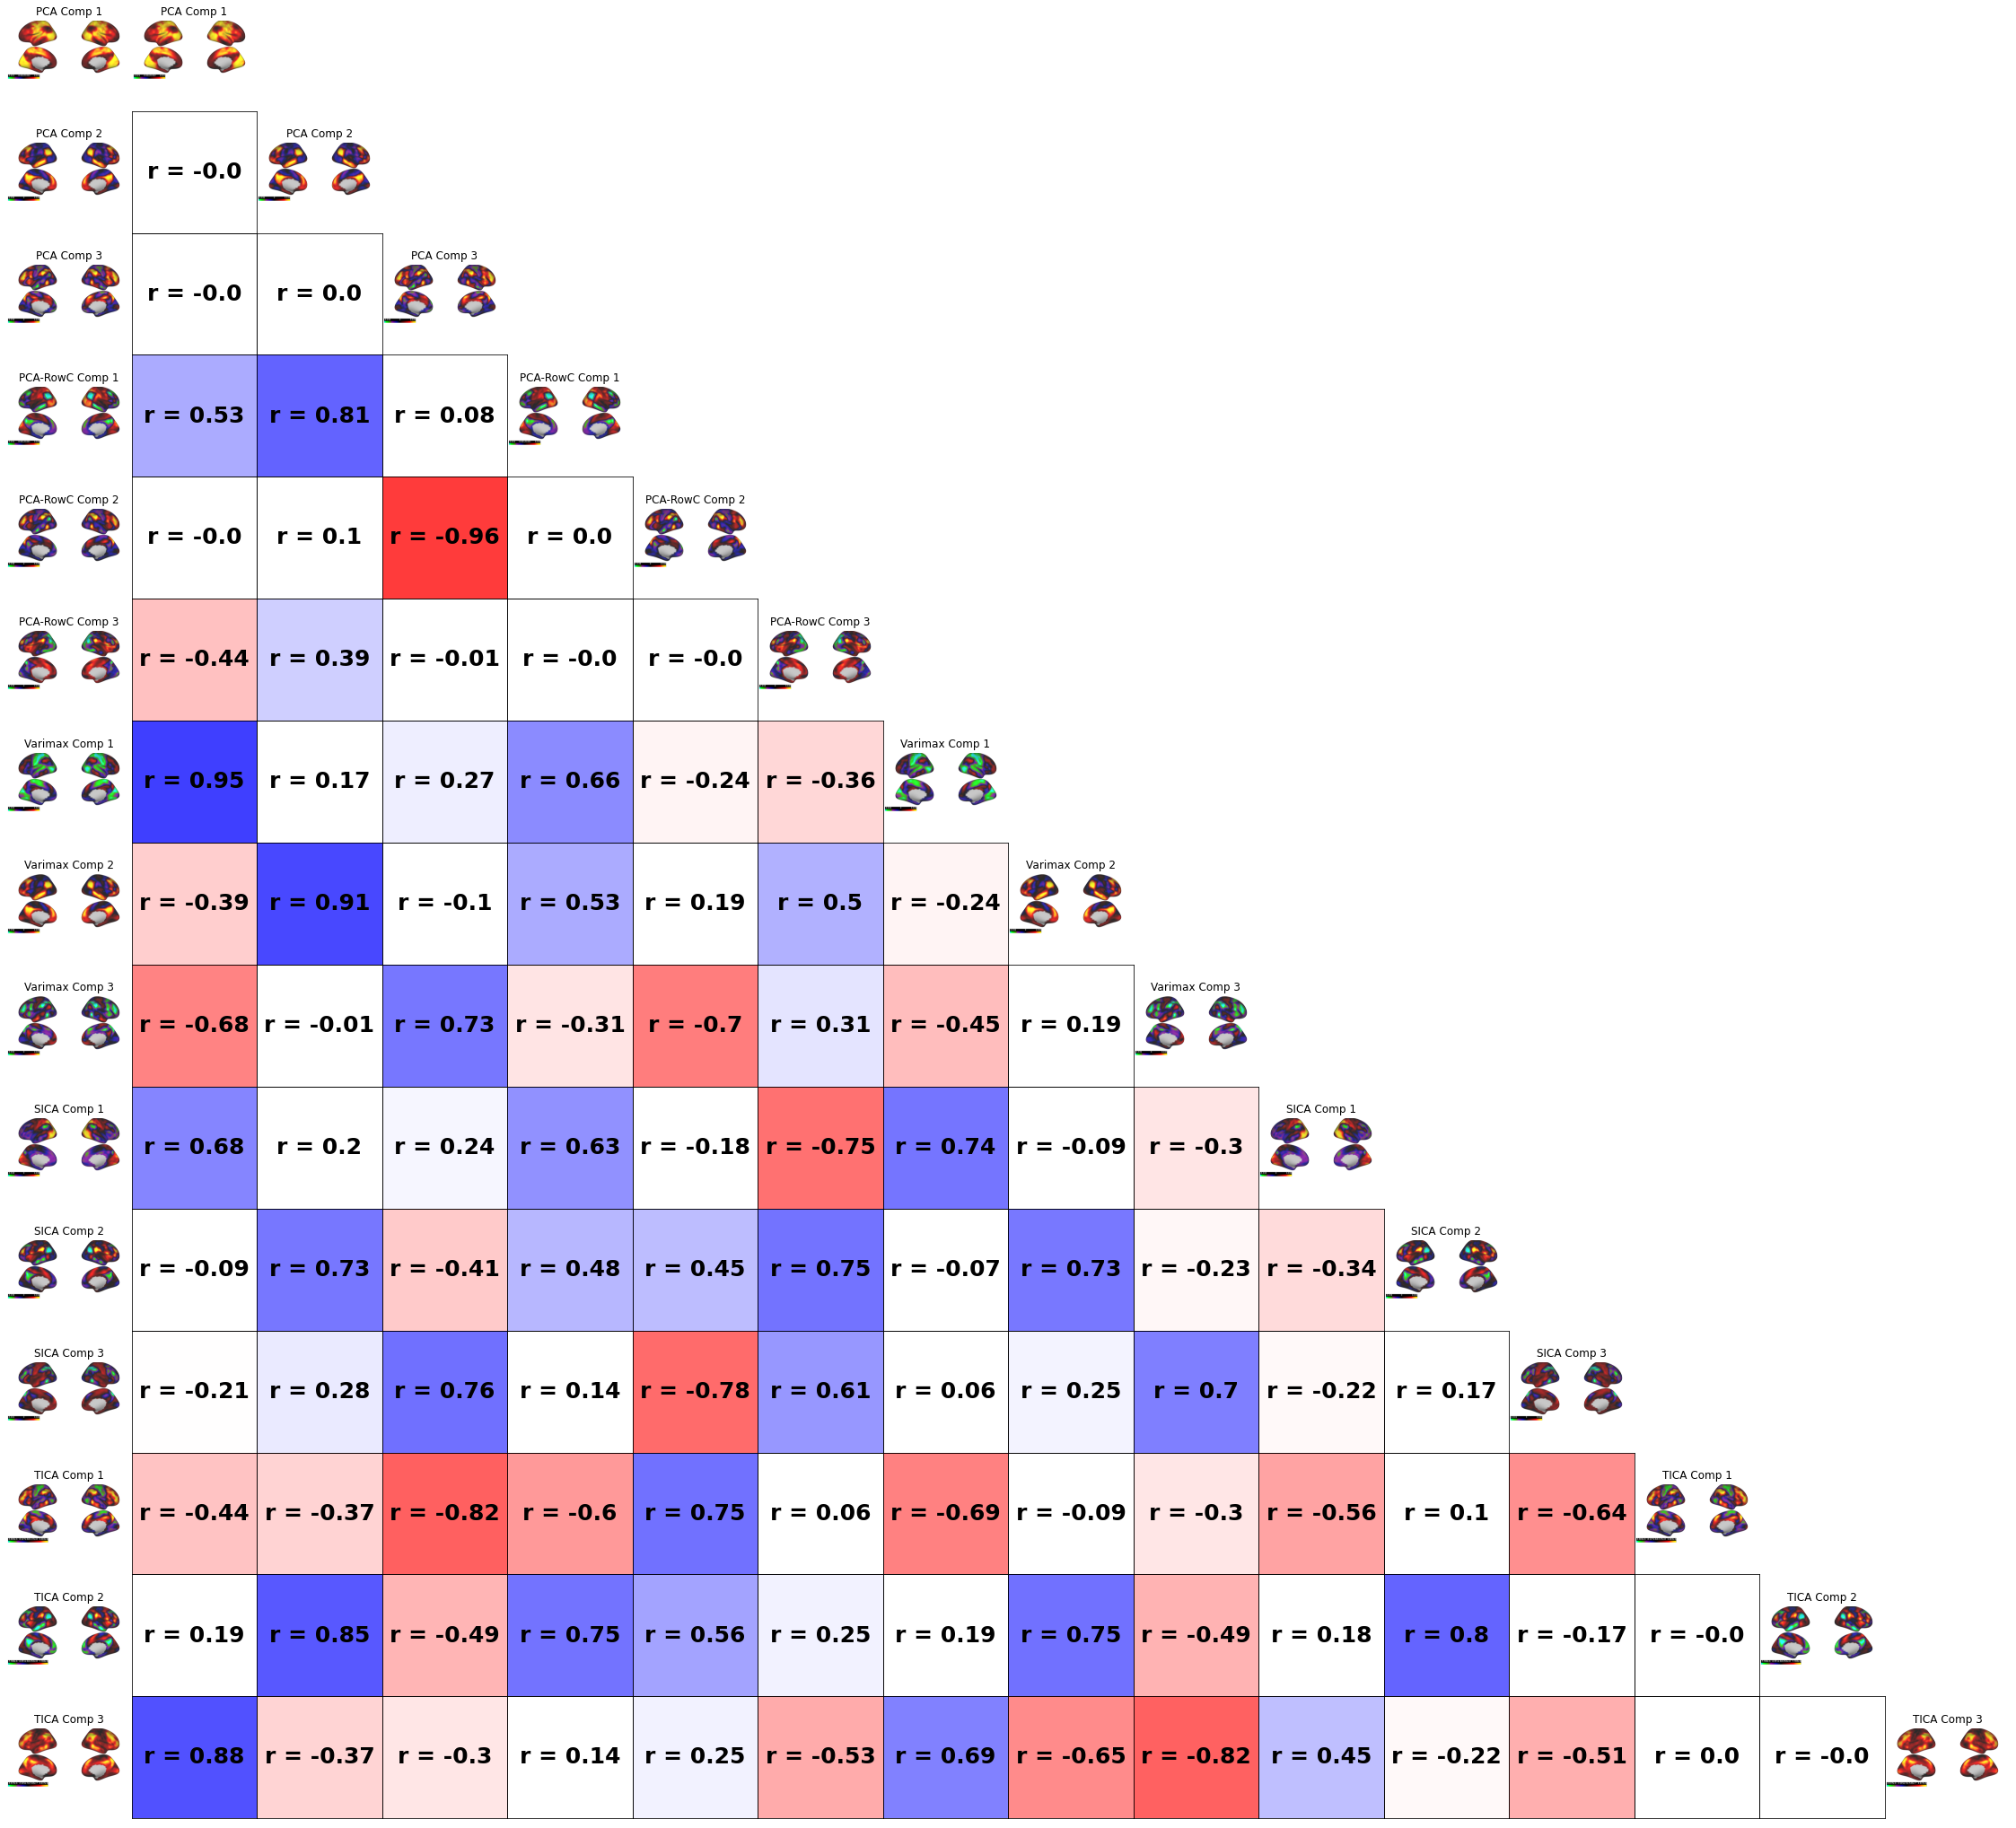

In [372]:
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
pcar_ts = pickle.load(open('demo_files/pcar_ts.pkl', 'rb'))
tica_ts = pickle.load(open('demo_files/tica_ts.pkl', 'rb'))
sica_ts = pickle.load(open('demo_files/sica_ts.pkl', 'rb'))
varimax_ts = pickle.load(open('demo_files/varimax_ts.pkl', 'rb'))

comp1_pca, comp2_pca, comp3_pca = pca_ts[:,0], pca_ts[:,1], pca_ts[:,2]
comp1_pcar, comp2_pcar, comp3_pcar = pcar_ts[:,0], pcar_ts[:,1], pcar_ts[:,2]
comp1_varimax, comp2_varimax, comp3_varimax = varimax_ts[:,0], varimax_ts[:,1], varimax_ts[:,2]
comp1_tica, comp2_tica, comp3_tica = tica_ts[:,0], tica_ts[:,1], tica_ts[:,2]
comp1_sica, comp2_sica, comp3_sica = sica_ts[:,0], sica_ts[:,1], sica_ts[:,2]

fps = ['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png', 
       'demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png', 
       'demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 
       'demo_files/pca_rest_varimax_comp2.png', 'demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 
       'demo_files/spatial_ica_comp2.png', 'demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 
       'demo_files/temporal_ica_comp2.png']
labels = ['PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3', 'PCA-RowC Comp 1', 'PCA-RowC Comp 2', 'PCA-RowC Comp 3', 
          'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 'SICA Comp 3',
          'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3']
all_comps = [comp1_pca, comp2_pca, comp3_pca, comp1_pcar, comp2_pcar, comp3_pcar, 
             comp1_varimax, comp2_varimax, comp3_varimax, comp1_sica, comp2_sica,
             comp3_sica, comp1_tica, comp2_tica, comp3_tica]

corr_mat = np.corrcoef(all_comps)

fig = plt.figure(figsize=(40, 40))
grid = gridspec.GridSpec(16, 16, wspace=0.0, hspace=0.0)
for indx, (fp, label) in enumerate(zip(fps, labels)):
    axr = fig.add_subplot(grid[indx+1,0])
    axc = fig.add_subplot(grid[indx+1, indx+1])
    img = mpimg.imread(fp)
    axr.set_title(label); axc.set_title(label)
    axr.imshow(img); axc.imshow(img)
    axr.axis('off'); axc.axis('off')
    
br_col = [None, 'blue', 'red']
for i in range(15):
    for j in range(i):
        if i != j:
            ax = fig.add_subplot(grid[i+1, j+1])
            r = corr_mat[i,j]
            r_sign = np.int(np.sign(r))
            ax.text(0.5, 0.5, f'r = {np.round(r, 2)}',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=25, fontweight='bold',
            transform=ax.transAxes)
            ax.patch.set_facecolor(br_col[r_sign])
            ax.patch.set_alpha(max(0,r*r_sign-0.2))
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        else:
            ax = fig.add_subplot(grid)

plt.show()

<font size='4'> As with the spatial maps, the time courses between the components of each analysis reveal striking similarities. In fact, all of the component time courses exhibit strong correlations with at least one of the component time courses from another analysis. The findings from both the spatial maps and time courses indicate that these analyses are capturing very similar phenomena. </font>

# <b>3. Are Different Zero-lag Analyses Capturing the Same Phenomena?</b>

<font size='4'> We've established above that the spatial and temporal properties of the zero-lag resting-state analyses are similar. The primary question is whether the spatial and temporal differences that do exist between these zero-lag analyses is indicative of physically different BOLD patterns, or multiple descriptions of the same physical BOLD pattern. In the following section, we 

<b>Eigendecomposition techniques</b> are well-suited for extracting these sorts of 'global' patterns. In the case of a symmetric matrix, eigendecomposition techniques decompose the matrix into an orthogonal set of basis vectors, known as eigenvectors, and associated scaling values, known as eigenvalues. Eigendecomposition applied to a covariance/correlation matrix is known as principal component analysis (PCA). The top N eigenvectors (and associated eigenvalues) or principal components of a covariance matrix represent the top N dimensions of variability in the data. This property of PCA makes it a popular tool for dimension reduction. In our case, it has a further utility: a re-occuring global spatiotemporal event that involves the majority of cortical bold time series should/might be reflected in one of the top principal components of the vertex-by-vertex correlation matrix.</font>

In [3]:
from run_cap_analysis import consecutive_timepoints
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

caps_p_res = pickle.load(open('results/caps_precuneus_results.pkl', 'rb'))
caps_p_res_norm = pickle.load(open('results/caps_precuneus_norm_results.pkl', 'rb'))

caps_sm_res = pickle.load(open('results/caps_sm_results.pkl', 'rb'))
caps_sm_res_norm = pickle.load(open('results/caps_sm_norm_results.pkl', 'rb'))

In [5]:
ts_segs_p = consecutive_timepoints(caps_p_res[2])
ts_segs_indx_p = [np.where(np.isin(caps_p_res[2], seg)) for seg in ts_segs_p]
ts_segs_clus_p = [caps_p_res[1][seg_indx] for seg_indx in ts_segs_indx_p]
ts_seg_len_p = [len(seg) for seg in ts_segs_p]

ts_segs_sm = consecutive_timepoints(caps_sm_res[2])
ts_segs_indx_sm = [np.where(np.isin(caps_sm_res[2], seg)) for seg in ts_segs_sm]
ts_segs_clus_sm = [caps_sm_res[1][seg_indx] for seg_indx in ts_segs_indx_sm]
ts_seg_len_sm = [len(seg) for seg in ts_segs_sm]

print(np.unique(caps_p_res[1], return_counts=True))
print(np.unique(caps_sm_res[1], return_counts=True))

(array([0, 1, 2], dtype=int32), array([2882, 1500, 4618]))
(array([0, 1, 2], dtype=int32), array([4029, 2989, 1982]))


In [6]:
%%capture 
# ^ supress printing
group_data_orig, hdr, zero_mask, _ = load_data_and_stack(50, 'gifti', global_signal=0)
selected_data_p = zscore(group_data_orig[caps_p_res[2], :])
selected_data_sm = zscore(group_data_orig[caps_sm_res[2], :])

In [9]:
write_to_gifti(group_data_orig[caps_p_res[2], :], hdr, 'test', zero_mask)

In [502]:
pca_p = PCA(n_components=50).fit_transform(selected_data_p)
pca_sm = PCA(n_components=50).fit_transform(selected_data_sm)

In [503]:
X_p = pairwise_distances(pca_p, metric='euclidean')
X_p_norm = pairwise_distances(zscore(pca_p.T).T, metric='euclidean')

X_sm = pairwise_distances(pca_sm, metric='euclidean')
X_sm_norm = pairwise_distances(zscore(pca_sm.T).T, metric='euclidean')

In [504]:
isomap_p = Isomap(metric='precomputed')
isomap_p_norm = Isomap(metric='precomputed')
isomap_sm = Isomap(metric='precomputed')
isomap_sm_norm = Isomap(metric='precomputed')
isomap_p.fit(X_p)
isomap_p_norm.fit(X_p_norm)
isomap_sm.fit(X_sm)
isomap_sm_norm.fit(X_sm_norm)

Isomap(metric='precomputed')

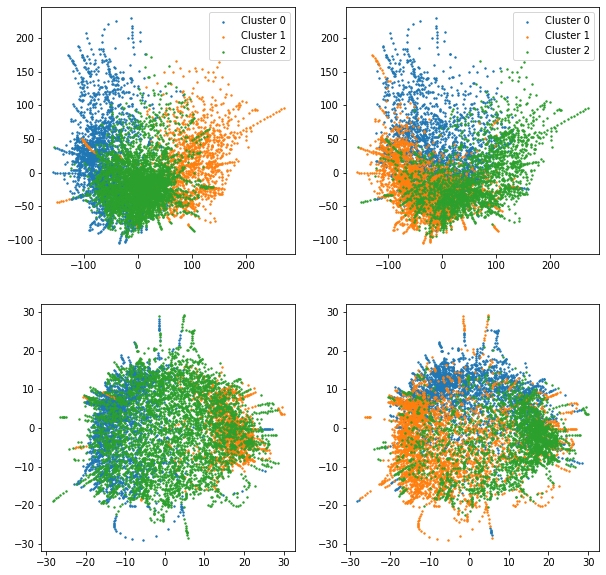

In [505]:
clus_labels = caps_p_res[1]
clus_labels_norm = caps_p_res_norm[1]
fig, ax = plt.subplots(2,2,figsize=(10,10))
comps = isomap_p.embedding_
for i in np.unique(clus_labels):
# for i in [0,1]:
    clus_indx = np.where(clus_labels == i)[0]
    ax[0,0].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2, label=f'Cluster {i}')
    ax[0,0].legend()

for i in np.unique(clus_labels_norm):
    clus_indx = np.where(clus_labels_norm == i)[0]
    ax[0,1].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2, label=f'Cluster {i}')
    ax[0,1].legend()
    
comps = isomap_p_norm.embedding_
for i in np.unique(clus_labels):
# for i in [0,1]:
    clus_indx = np.where(clus_labels == i)[0]
    ax[1,0].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2)

for i in np.unique(clus_labels_norm):
    clus_indx = np.where(clus_labels_norm == i)[0]
    ax[1,1].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2)    

plt.show()

In [290]:
clus_labels = caps_sm_res[1]
clus_labels_norm = caps_sm_res_norm[1]
fig, ax = plt.subplots(2,2,figsize=(10,10))
comps = isomap_sm.embedding_
# for i in np.unique(clus_labels):
for i in [1,2]:
    clus_indx = np.where(clus_labels == i)[0]
    ax[0,0].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2, label=f'Cluster {i}')
    ax[0,0].legend()

for i in np.unique(clus_labels_norm):
    clus_indx = np.where(clus_labels_norm == i)[0]
    ax[0,1].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2, label=f'Cluster {i}')
    ax[0,1].legend()
    
comps = isomap_sm_norm.embedding_
# for i in np.unique(clus_labels):
for i in [1,2]:
    clus_indx = np.where(clus_labels == i)[0]
    ax[1,0].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2)

for i in np.unique(clus_labels_norm):
    clus_indx = np.where(clus_labels_norm == i)[0]
    ax[1,1].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2)
    
plt.show()

NameError: name 'caps_sm_res' is not defined

In [592]:
ts_segs_clus_p_joined = [clus for seg in ts_segs_clus_p for clus in np.concatenate([[np.NaN],seg,[np.NaN]])]
ts_segs_clus_sm_joined = [clus for seg in ts_segs_clus_sm for clus in np.concatenate([[np.NaN],seg,[np.NaN]])]

transition_seg_p = transition_matrix(ts_segs_clus_p_joined)
transition_seg_sm = transition_matrix(ts_segs_clus_sm_joined)

print(np.unique(caps_p_res[1], return_counts=True))
print(np.unique(caps_sm_res[1], return_counts=True))

(array([0, 1, 2], dtype=int32), array([2882, 1500, 4618]))
(array([0, 1, 2], dtype=int32), array([4029, 2989, 1982]))


In [593]:
np.round(transition_seg_p, 3)

array([[0.94 , 0.   , 0.06 ],
       [0.   , 0.875, 0.125],
       [0.064, 0.022, 0.914]])

In [594]:
np.round(transition_seg_sm,3)

array([[0.889, 0.049, 0.062],
       [0.11 , 0.89 , 0.   ],
       [0.07 , 0.001, 0.93 ]])

## 2.1 Eigendecomposition and Correlation-Based Analysis - Three Dominant Patterns

### 2.1.1 Principal Components of Cortical BOLD Signals

<font size="4">We conducted a PCA analysis on the same resting-state data from 50 HCP subjects and visualize the spatial weights of the first three principal components below:</font>

In [13]:
ipyplot.plot_images(['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'], 
                    ['Component 1', 'Component 2', 'Component 3'], img_width=500)

<font size='4'>The spatial pattern of weights looks very similar between the first two principal components. Specifically, the sensorimotor, superior parietal and visual cortex (outside primary visual) are contrasted with the DMN (and primary visual cortex). The first component has a unipolar pattern with all positive weights, but less strong positive weights in the DMN. The second component has a bipolar pattern - both positive and negative weights with negative weights in the DMN. Notice that the spatial weights of the first two PCA components reflect the primary dynamics of the QPP: both have a contrasting pattern of weights between the DMN and the early peak amplitude regions (e.g. sensorimotor regions) - less vs more positive in component 1, and positive vs. negative in component 2, respectively. The third principal component is a more complex pattern than the unipolar and bipolar pattern of the first and second principal component, respectively. </font>

### 2.1.2 Manifold Learning and Connectivity Gradients

<font size='4'> PCA is a well-known eigendecomposition approach in fMRI research. More importantly, it is related to a wide variety of analytic approaches popular in the fMRI liteature. In fact, PCA is closely related to the recent resurgence of eigendecomposition methods in resting-state fMRI analysis that has gone under the name of 'functional connectivity gradients'. The seminal study of functional connectivity gradients by Margulies et al. (2016 - PNAS) introduced the concept of connectivity gradients to the study of resting-state fMRI. To derive functional connectivity gradients, manifold learning algorithms, such as diffusion map embedding (as in Margulies et al. 2016) and Laplacian Eigenmaps, are applied to a vertex-by-vertex affinity/similarity matrix (or voxel-by-voxel). A fixed number of dimensions or manifolds are returned from the manifold learning algorithm, representing orthogonal sub-spaces that preserve the distances (in a Euclidean sense) between vertices/voxels. Of course, PCA has a very close relationship with these approaches. Both diffusion maps and Laplacian Eigenmaps involve an eigendecomposition of a modified similarity matrix, the graph Laplacian, analagous to the covariance/correlation matrix used by PCA. Further, in the case of a linear kernel, Laplacian Eigenmaps return equivalent embeddings to kernel PCA (a varient of PCA on affinity/kernel matrices; Ham et al. 2004). Vos de Wael et al. (2020) have noted the similarity in connectivity gradients returned by diffusion maps, Laplacian Eigenmaps, and PCA. Thus, we might expect the application of Laplacian Eigenmaps applied to a vertex-by-vertex (linear) similarity matrix to return similar components. We computed the first two Laplacian Eigenmaps from the vertex-by-vertex cosine similarity matrix (the cosine metric is equivalent to the Pearson correlation in mean-centered data such as ours). Two side notes:</font>   
    
    1. In Marguiles et al. (2016), each row of the cosine similarity matrix was thresholded, such that row values below the 90% percentile cosine similairty value of that row were set to 0. This amounts to converting the similarity matrix into something like a nearest neighbor graph. This is a pre-processing step, as opposed to an operation within the Eigenmap calculation itself. We did not conduct this row-based thresholding procedure to ensure pre-processing steps did not differ between the PCA analysis shown above and the Laplacian Eigenmap calculation. 
    2. The results were not dependent on the choice of similarity/affinity metric - Laplacian Eigenmaps with a Gaussian kernel (gamma=1) returned identical results.
    
<font size='4'> Below we compare the first two Laplacian Eigemaps to our principal component solution.</font>

In [14]:
ipyplot.plot_images(['demo_files/diffusion_emb_comp0.png', 'demo_files/diffusion_emb_comp1.png', 
                     'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'], 
                    ['Laplacian Eigenmap 1', 'Laplacian Eigenmap 2', 'Principal Component 2', 'Principal Component 3'], img_width=500)

<font size='4'> The first and second Laplacian Eigenmap match the second and third principal components from the PCA solution. The difference between the PCA and Laplacian Eigenmap solution is that the first principal component seems is missing from the Laplacian Eigenmap solution. Thus, as Vos de Waal et al. (2020) have observed, PCA and Laplacian Eigenmaps return *almost* equivalent solutions. Of note, Vos de Waal et al. (2020) also demonstrate that diffusion maps (the algorithm of Marguiles et al. 2016) returns equivalent results to Laplacian Eigenmaps. Thus, for resting-state cortical BOLD signals, the manifold learning algorithms of connectivity gradients and PCA return almost equivalent findings. The missing 'all-positive' first principal component is likely due to the different matrices that are decomposed by PCA and Laplacian Eigenmaps (and diffusion maps). The Laplacian Eigenmap algorithm performs an eigendecomposition on the normalized graph Laplacian. In our analysis, the normalized graph Laplacian is the vertex-by-vertex cosine similiarity matrix row-wise normalized by the following quantity: the inverse of the square root of the sum of the weights within each row (i.e. the degree matrix). Given the equivalence of the cosine and Pearson correlation metrics for centered data, the only difference between the PCA used above and Laplacian Eigenmaps, is that the eigendecomposition is performed on a correlation matrix versus a row-wise weighted correlation matrix, respectively. Thus, the row-wise normalization of the similarity matrix seems to drop the first principal component, while preserving the second and third components. Either way, we can produce the same solution with PCA as the Laplacian Eigenmaps if the subject-concatenated data matrix (time by vertex matrix) is mean centered along the rows (sometimes known as T-Mode PCA). This normalization is sometimes called frame-by-frame intensity subtraction in the fMRI literature. We present the first two principal components from the correlation matrix derived from the row-centered data matrix below:

In [15]:
ipyplot.plot_images(['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png'], 
                    ['Component 1 - Row Normalization', 'Component 2 Row Normalization'], img_width=500)

<font size='4'>The PCA solution is now identical to the Eigenmap solution in the first two components. Note, the principal components derived from the eigendecomposition are sign ambiguous - the sign of the weights in the row-normalized PCA component one can be arbitrarily flipped to match component two in the ordinary PCA. Thus, row (frame-by-frame) mean centering eliminates the first principal component. Row normalization has the same practical effect as global signal regression - a finding we discuss in more detail below.

### 2.1.3 Seed-Based Correlation Analysis, The Task-Positive/Task-Negative Network and Eigendecomposition Approaches

<font size='4'> PCA, and manifold learning approaches involving eigendecomposition techniques, have been shown to return similar results, and under special conditions, return identical results. More interestingly, seed-based correlation analyses, with proper seed location, seem to yield very similar results to the eigendecomposition approaches. More specifically, we can replicate the spatial patterns of the first, second and third principal components (first and second in the Laplacian Eigenmaps) by correlating all vertices' BOLD signals with correctly placed seed regions. Seed-based correlation analysis involves correlating each vertices' BOLD timeseries with a seed timeseries, derived from a region of interest. For our analysis, two region of interests are used, belonging to the two contrasted regions of the first and second principal components. The first seed was selected as the average of matching left and right hemisphere vertices in the Precuneus of the DMN, and the second seed was selected as the average of matching left and right vertices in the somatosensory cortex. An additional preprocessing step known to be important for seed-based correlation analysis is what is known as global signal regression - i.e. regressing out the arithmetic mean of all gray matter (or cortical) voxels/vertices in the brain. We display the seed-based correlation analyses for the two seed timeseries with and without global signal regression as a preprocessing step below: </font>

#### Precuneus Seed Correlation Analysis

In [17]:
ipyplot.plot_images(['demo_files/fc_map_precuneus_seeds.png', 'demo_files/fc_map_precuneus.png', 
                     'demo_files/fc_map_precuneus_gs.png'], 
                    ['Precuneus seeds', 'Seed-Based Correlation - Precuneus Seed', 
                     'Seed-Based Correlation - Precuneus Seed - Global Signal Regressed'], img_width=500)

#### Somatosensory Seed Correlation Analysis

In [18]:
ipyplot.plot_images(['demo_files/fc_map_sm_seeds.png', 'demo_files/fc_map_sm.png', 'demo_files/fc_map_sm_gs.png'], 
                    ['Sensorimotor seeds', 'Seed-Based Correlation - Sensorimotor Seed', 
                     'Seed-Based Correlation - Sensorimotor Seed - Global Signal Regressed'], img_width=500)

<font size='4'> Interestingly, both seed-based correlation analysis without global signal regression return an almost globally positive (slight negative correlation in certain areas) pattern of correlations. The global positive correlation pattern from both seeds precisely matches the contrast between the DMN and other regions observed in the first principal component. Note, the pattern is flipped in the Precuneus (stronger weights in the DMN) due to the placement of the seed in the DMN. Globally positive correlations is a ubiquitous finding of seed-based correlation analysis without global signal regression, as first observed by Fox et al. (2005 - PNAS; 2008 - Journal of Neurophysiology). On the other hand, when Fox et al. (2005; 2009) regress out the global signal, they found what has been commonly referred to as the Task Positive and Task Negative (TP/TPN) networks or pattern. We see the exact same TP/TN pattern from the Precuneus-seeded correlation analysis when we regress out the global signal. Interestingly, the TP/TN pattern precisely matches the second principal component - a bipolar contrast between weights within the TN versus TP. The pattern of the Somatosensory-seeded correlation analysis on global signal-regressed data returns a more complex pattern of negative and positive correlations. Interestingly, this correlation pattern precisely resembles the third principal component weights - with flipped sign due to the seed placement in the somatosensory cortex.</font>

<font size='4'> The important question is why do two seemingly disparate analytic approaches - eigendecompositions of vertex-by-vertex similarity matrices and seed-based correlation analysis w/ and w/o global signal regression - return the same correlation patterns across the cortex? Additionally, why is global signal regression a factor in whether the results of seed-based correlation and eigendecomposition results match? It's helpful to consider a seed-based correlation analysis in the context of the vertex-by-vertex correlation matrix. Each entry in this matrix is the correlation value in BOLD timeseries between a vertex $i$ (row) and a vertex $v$ (column). In the case of a single vertex seed (vertex $i$), a seed-based correlation analysis corresponds to a row (or column) of the correlation matrix - the similarity in BOLD timeseries between vertex $i$ (row $i$) and all other vertices (all columns). The eigendecomposition of the vertex-by-vertex correlation matrix returns the *dominant* directions of variance encoded by the covariance/correlation matrix - i.e. those weighted combination of vertices along which the data have the greatest variance. These are the principal components. The first principal component is the weighted combination of vertices belonging to the dominant direction of variance encoded in the correlation matrix. To the extent that this dominant pattern of vertices is encoded in a given row - vertex $i$ - of the correlation matrix, the columns of that row corresponding to the correlation of each vertex with vertex $i$ will resemble the first principal component pattern. Of course, whether any given row $i$ resembles the first principal component depends on the correlation pattern of that vertex . In our case, the vertices (rows) in the Precuneus and Somatosensory seeds strongly exhibit the dominant pattern of correlations among the vertices of the vertex-by-vertex correlation matrix that is encoded in the first principal component.</font>

<font size='4'>But this doesn't explain why global signal regression returns the second and third principal components in the Precuneus and Somatosensory seed-based correlation anlayses, respectively. The explanation resides in the identification of the first principal component with the global signal, which we discuss below.</font>

### 2.1.4 The First Principal Component And the Global Signal

<font size='4'>Below is the global signal beta map derived from a simple linear regression analysis of each vertex with the global signal, displayed side-by-side with the first principal component:</font>

In [20]:
ipyplot.plot_images(['demo_files/gs_map.png', 'demo_files/pca_rest_comp0.png'], 
                    ['Global Signal Beta Map', 'Principal Component 1'], img_width=500)

<font size='4'> Outside of slightly less positive patterns along the medial sensorimotor cortex in the global signal beta map, both patterns exhibit strong positive weights in the superior parietal, sensorimotor and visual cortices (outside of the primary visual). Moreover, the correlation between the time series of the global signal and the first principal component reveals the signals are almost statistically indistinguishable (*r=0.978*): </font>

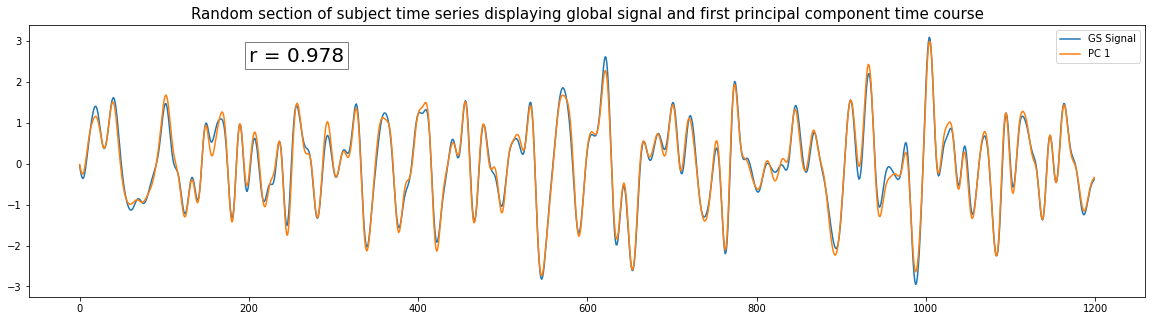

In [18]:
pca_results = pickle.load(open('demo_files/pca_rest_results.pkl', 'rb'))
gs_signal = pickle.load(open('demo_files/gs_results.pkl', 'rb'))
comp0_ts = pca_results['pc_scores'][:, 0]
corr_coef = np.corrcoef(comp0_ts.T, gs_signal.T)[0,1]

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(zscore(gs_signal[1200:2400]), label='GS Signal')
ax.plot(zscore(comp0_ts[1200:2400]), label='PC 1')
ax.set_title('Random section of subject time series displaying global signal and first principal component time course', fontsize=15)
ax.text(200,2.5, r'r = {}'.format(np.round(corr_coef,3)), fontsize=20, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()
plt.show()

<font size="4"> We are not the first to make this observation. Carbonell et al. (2013 - Brain Connectivity) explicitly modeled the global signal as the principal component most correlated with the mean signal of whole-brain BOLD time series. They found that the most correlated principal component was the <b>first principal component</b>. </font>

<font size='4'>With these findings we are now in a position to directly relate the eigendecomposition results and the seed-based correlation analyses. As already observed, the seed-based correlation analysis on non global signal-regressed data returns an all positive correlation pattern similar to that observed in the first principal component. Keeping in mind that the first principal component essentially yields a time series identical to the arithmetic mean of cortical BOLD signals, <b>regression of the global signal and orthogonalizing with respect to the first principal component has identical effects on the data</b>. What is left over are the modes of variability outside of the first principal component. For the Precuneus seed, the seed correlations return the second principal component. For the somatosensory seed, the seed correlations return to the third principal component. The reason the Precuneus and somatosensory seed return different component patterns is due to the placement of seeds relative to the first principal component - the Precuneus seed is placed in a location with weak component weights and the somatosensory is placed in a location of strong component weights (<b>Sec 2.1.1</b>). Orthogonalization of the first principal component or global signal regression has the most prominent effect on areas with strong component weights on the first principal component - i.e. the sensorimotor cortex where the somatosensory seed was placed. Thus, in the second principal component, the area with the weakest weights on the first component - i.e. the DMN - now contains the strongest weights, and the sensorimotor cortex weights are close to 0. With global signal regressed data (roughly identical with orthogonalizing to the first component), the Precuneus seed (an area of the DMN) correlated with all cortical vertice returns the TP/TN contrast with strongest weights in the DMN. Orthogonal to the second and first components, is the third principal component. Orthogonalizing with respect to the second component, has the most prominent effect on areas with strong component weights - i.e. the DMN. Thus, in the third principal component, the area with the weakest weights on the second principal component - i.e. the sensorimotor cortex, a non-DMN area is located - now has the strongest weights. Notice, that the TP/TN pattern of the first principal component from the row-mean-centered PCA in <b>Sec 2.1.2</b> also arises from the exact same global signal regression mechanism: mean centering of the cortical signal removes the mean BOLD signal across the vertices within a single TR - shown to have the same effect as global signal regression by Liu et al. (2017 - Neuroimage). Thus, frame-by-frame intensity subtraction PCA and Laplacian Eigenmaps have implicitly removed the first principal component before the eigendecomposition step.</font>

## 2.2 The Interpretation of Eigendecomposition and Seed-Based Correlation Results

<font size='4'> The points above are not trivial for resting-state fMRI researchers. In fact, these points lead to an important conclusion: the correlation patterns observed after global signal regression are predictable effects of orthogonalization with respect to the first principal component. In other words, the relationship between the first component - that tracks the global signal - and the second component - the observed contrast between the TP/TN pattern - is a direct result of the orthogonalization with respect to the first principal component - not two independent BOLD patterns. Many have argued that global signal regression introduces anticorrelation between the TP and TN networks (Murphy et al. 2009 - Neuroimage), but this does not go far enough; the TP/TN pattern is a complementary description of the global signal (first principal component) induced by orthogonalizing with respect to the global signal. The fact that PCA (and global signal regression) yields these predictable patterns is well-known in the Atmospheric and Climate sciences, and has been for quite some time (Horel, 1981; Richman, 1986). Note, principal component analysis (PCA) is often referred to as Empirical Orthogonal Functions (EOF) in that literature. In the words of Horel (1981):</font> 
    
    "The spatial orthogonality of the eigenvectors is a strong and often undesirable constraint imposed on the principal component solution. While the first principal component and its eigenvector are not influenced by this constraint, the remaining eigenvectors often bear predictable geometric relationships to the first eigenvector. For example, if the first eigenvector is of one sign throughout the domain, the second will generally be bipolar with its zero line passing through the highest value of the first eigenvector; the third one may be either bipolar (rotated with respect to the other two) or a more complicated pattern with its maxima near zero lines of the other eigenvectors" (Horel, 1981; Pg. 2081)
    
<font size='4'> This is *exactly* what we observed above in our PCA analysis of cortical BOLD signals: the first principal component is positive sign; the second principal component is bipolar, or flip-flopped around the zero point of the first eigenvector; the third principal component is a more complex, mixed sign pattern that is multipolar. In other words, the pattern of spatial weights between these three components seems to be due to the orthogonality constraint of PCA. The exact same mechanism is at work with global signal regression and seed-based correlation analysis. The pattern of spatial correlations exhibited by the TP/TN pattern is a direct result of orthogonalizing with respect to the first principal component or global signal. These observations challenge the claim that two independent physical patterns exist in the data - a global signal pattern and a TP/TN pattern. In fact, when we relax the stringent assumptions of eigendecomposition, we see the reality is much more complicated.  
    

## 2.3 Relaxing Assumptions and the Concept of a 'Statistical Filter'

### 2.3.1 PCA Rotation

<font size='4'> The extraction of orthogonal dimensions of maximum variance may be a desirable property in certain areas of application. Two global patterns in the data might be reflected as orthogonal dimensions that account for maximum variance in the data. But as we've shown above, these properties applied to resting-state BOLD signals can lead to spurious conclusions. Fortunately, we don't have to live with these assumptions - we can drop them and replace them with others. We don't have to start from scratch either. We can 'rotate' the original PCA axes so that they fit some other criteria. Some rotations drop the maximum variance and orthogonality criteria, and rotate the PCA axes so that the sparsity of the spatial weights is maximized. These are known as rotation towards 'simple structure' in the social science literature. Thus, the original PCA solution begins to look more like a clustering solution (an illustration of rotation and simple structure is provided in <b>Appendix A</b>). Two popular simple structure rotations are Varimax and Promax. Varimax is an orthogonal rotation - it drops the temporal uncorrelatedness of the principal component time series, but keeps the spatial orthogonality of the spatial weights.  Promax is an oblique rotation - it drops both the temporal uncorrelatedness of the principal component time series and the spatial orthogonality of the spatial weights. Due to the relaxation of both temporal and spatial orthogonality, Promax often yields sparser solutions than Varimax. </font>
    
<font size='4'>While not often thought of in this manner, Independent Component Analysis (ICA) can be described as a principal component rotation method (Hannachi et al. 2009 - Journal of Climate). ICA models the data in terms of a linear mixture of statistically independent sources. 'Independence' is a stronger criterion than the orthogonal or uncorrelatedness assumption of PCA. Independence implies uncorrelatedness, but the converse is not always true. PCA is almost always used as a 'pre-whitening' step before the ICA algorithm. Pre-whitening reduces the number of parameters estimated by the ICA algorithm and involves 'uncorrelating' the data. PCA produces orthogonal principal componens and thereby achieves the uncorrelatedness required by the 'pre-whitening' step. For a given set of N principal component spatial weights, ICA finds an N * N rotation matrix (i.e. 'unmixing matrix') that maximizes the statistical independence between the N independent components. Relative to the 'simple structure' rotations above, the ICA rotation drops the temporal uncorrelatedness of the principal component time series and enforces statistical independence on the spatial weights. The simple structure rotations and ICA have only so far been described as applying to the spatial weights, but one could just as well enforce sparsity or independence in the temporal domain. Temporal ICA is an increasingly popular approach in resting-state fMRI and estimates statistically independent BOLD time courses. </font>

### 2.3.2 Rotating the First and Second Principal Component

<font size='4'>PCA rotation allows us to avoid the orthogonality criterion of PCA. As we've shown above, this criterion leads to predictable relationships between the first and second principal components (and second and third, and so on). Of course, the criterion of the original PCA solution have now been replaced by others. We conducted a series of rotations of the global signal and TP/TN two-component PCA solution: Varimax rotation, Promax rotation, Spatial ICA and Temporal ICA. To understand what dynamics 

In [237]:
ipyplot.plot_images(['demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png'], 
                    ['Component 1 - Rotated', 'Component 2 - Rotated'], img_width=300)

<font size='4'> The global signal component, the component with all positive weights from the original PCA, has now disappeared. The two rotated principal components correspond to two flip-flopped patterns of the TP/TN. This does not imply that the global signal, <i>defined in terms of the arithmetic mean of the BOLD signals</i>, is no longer correlated with these rotated components. When we compute the correlation between the first principal component of the rotated solution with the global signal: </font>

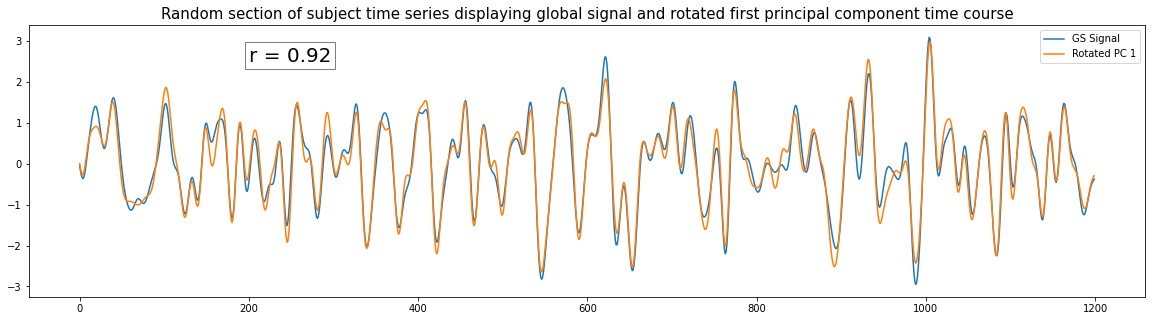

In [2]:
pca_results = pickle.load(open('demo_files/pca_rest_varimax_results.pkl', 'rb'))
gs_signal = pickle.load(open('demo_files/gs_results.pkl', 'rb'))
comp0_varimax_ts = pca_results['U'][:, 0]
corr_coef = np.corrcoef(comp0_varimax_ts.T, gs_signal.T)[0,1]

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(zscore(gs_signal[1200:2400]), label='GS Signal')
ax.plot(zscore(comp0_varimax_ts[1200:2400]), label='Rotated PC 1')
ax.set_title('Random section of subject time series displaying global signal and rotated first principal component time course', 
             fontsize=15)
ax.text(200,2.5, r'r = {}'.format(np.round(corr_coef,3)), fontsize=20, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()
plt.show()

In [60]:
import pandas as pd
tica_results = pickle.load(open('results/t_ica_results.pkl', 'rb'))
sica_results = pickle.load(open('ica_results.pkl', 'rb'))
pcar_results = pickle.load(open('demo_files/pca_rest_varimax_results.pkl', 'rb'))
pca_results = pickle.load(open('demo_files/pca_rest_results.pkl', 'rb'))

comp0_varimax_ts = pcar_results['U'][:, 0]
comp1_varimax_ts = pcar_results['U'][:, 1]
comp0_ts = pca_results['U'][:, 0]
comp1_ts = pca_results['U'][:, 1]
tica_comp0 = tica_results[1][0, :]
tica_comp1 = tica_results[1][1, :]
sica_comp0 = sica_results[1][0, :]
sica_comp1 = sica_results[1][1, :]
corr_mat = np.corrcoef([comp0_varimax_ts, comp1_varimax_ts, comp0_ts, comp1_ts,
             tica_comp0, tica_comp1, sica_comp0, sica_comp1])
labels = ['Varimax Comp 0', 'Varimax Comp 1', 'PCA Comp 0', 'PCA Comp 1', 
          'T-ICA Comp 0', 'T-ICA Comp 1', 'S-ICA Comp 0', 'S-ICA Comp 1']
pd.DataFrame(corr_mat, index=labels, columns=labels).round(3)

Varimax Comp 0  Varimax Comp 1  PCA Comp 0  PCA Comp 1  \
Varimax Comp 0           1.000          -0.345       0.979       0.203   
Varimax Comp 1          -0.345           1.000      -0.528       0.849   
PCA Comp 0               0.979          -0.528       1.000      -0.000   
PCA Comp 1               0.203           0.849      -0.000       1.000   
T-ICA Comp 0             0.387           0.732       0.192       0.981   
T-ICA Comp 1            -0.922           0.681      -0.981       0.192   
S-ICA Comp 0            -0.634          -0.356      -0.496      -0.731   
S-ICA Comp 1             0.197           0.181       0.139       0.295   

                T-ICA Comp 0  T-ICA Comp 1  S-ICA Comp 0  S-ICA Comp 1  
Varimax Comp 0         0.387        -0.922        -0.634         0.197  
Varimax Comp 1         0.732         0.681        -0.356         0.181  
PCA Comp 0             0.192        -0.981        -0.496         0.139  
PCA Comp 1             0.981         0.192        -0.731         0.295  
T-ICA Comp 0           1.000         0.000        -0.813         0.316  
T-ICA Comp 1           0.000         1.000         0.347        -0.080  
S-ICA Comp 0          -0.813         0.347         1.000         0.079  
S-ICA Comp 1           0.316        -0.080         0.079         1.000

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 9.78950130e-02,  1.01519525e-01,  1.03616414e-01,  1.03366598e-01,
         9.99676169e-02,  9.27637049e-02,  8.13709212e-02,  6.57765721e-02,
         4.63948766e-02,  2.40668065e-02,  3.80737310e-07, -2.43311405e-02,
        -4.73283881e-02, -6.74834787e-02, -8.35372436e-02, -9.46183177e-02,
        -1.00330428e-01, -1.00776309e-01, -9.65167948e-02, -8.84737410e-02,
        -7.77937148e-02]),
 <matplotlib.lines.Line2D at 0x118d21150>)

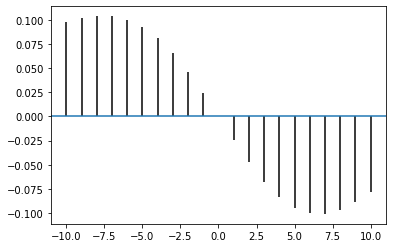

In [42]:
plt.xcorr(ica_comp, ica_comp1)

<font size='4'>The first rotated principal component, resembling the TP/TN pattern, and the global signal are almost statistically indistinguishable. Thus, while the original PCA solution might seem to suggest that there is a separable global signal and TP/TN pattern, we see that this inference is based on the mathematical constraints of the unrotated PCA, rather than a fact of BOLD signals themselves. When we relax the spatial orthogonality of the principal components, we see quite a tight relationship between the oscillations of the arithmetic mean of the cortical time series, and the TP/TN pattern. <b>In other words, the global signal and TP/TN are complementary descriptions of the same pattern.</b> </font>

## 2.3 Eigendecomposition, Seed-Based Correlation and The QPP

<font size='4'> We have demonstrated above that various eigendecomposition approaches and seed-based correlation analyses return surprisingly consistent results. Specifically, we've shown that seed-based correlation analyses return similar patterns to (at least) the first three principal components (and components of manifold learning techniques). Further, we've demonstrated that the multiple patterns produced by seed-based and eigendecomposition analyses - the global signal and the task-positive/task-negative pattern - are complementary descriptions of a single spatial covariance pattern of BOLD signals across the cortex.</font>

<font size='4'> We have yet to tie this line of argument and results to the quasiperiodic pattern (QPP) originally observed by Keilholz and colleagues. In the rest of this demo, we argue that the spatial covariance pattern of BOLD signals detected by static eigendecomposition and seed-based correlation approaches are simply descriptions of the dynamic BOLD fluctuations of the QPP.</font>

### 2.3.1 The relationship between the first principal component and the QPP

<font size='4'> There is already good evidence that we should expect fluctuations of the first principal component and the QPP to be closely related. Yousefi et al. (2018) has already noted a strong relationship between the global signal and the QPP. They found that the QPP was highly correlated with the global signal (median correlation of 0.78 across individuals subjects), modeled as the arithmetic mean of the grey matter voxels. In addition, we've already demonstrated that the first principal component is almost statistically indisguishable from the arithmetic mean of all cortical vertices - i.e. the global signal. This indicates that there may be a more fundamental relationship between these two signals. Thus, we computed the cross-correlation between the first principal component time series and the time series of the QPP (i.e. the sliding window correlation time series). We used a cross-correlation approach because the phase of the QPP fluctuation is arbitrary - i.e. depends on the starting point of the algorithm.</font>

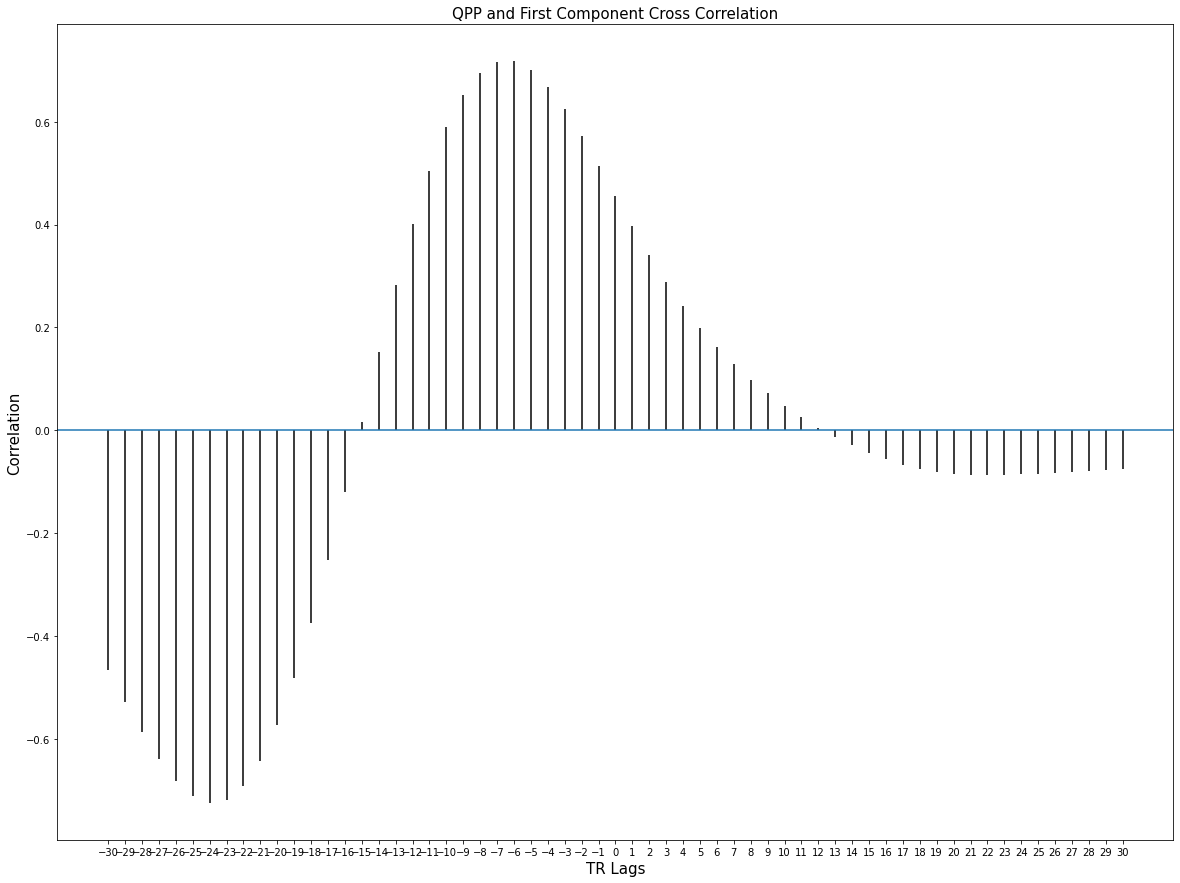

In [25]:
pca_results = pickle.load(open('demo_files/pca_rest_results.pkl', 'rb'))
comp0_ts = pca_results['U'][:, 0]
qpp_results = pickle.load(open('demo_files/qpp_results.pkl', 'rb'))
fig, ax = plt.subplots(figsize=(20,15))
ax.xcorr(qpp_results[3], comp0_ts, maxlags=30)
ax.set_title('QPP and First Component Cross Correlation', fontsize=15)
ax.set_xticks(np.arange(-30, 30+1, 1))
ax.set_xlabel('TR Lags', fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)
plt.show()

<font size='4'>The first principal component time series tracks the fluctuations of the QPP very closely (*r=0.72* at a lag of 6 TRs). If we use the first principal component of the rotated component solution (<b>Sec 2.2</b>) we get identical results (*r=0.72* at a lag of 6 TRs; timeseries not shown).</font>

<font size='4'> As noted above, the patterns of weights in the first principal components (as well as the second principal component) primarily contrast the early and late phases of the QPP: more positive weights in the early sensorimotor, superior parietal and lateral visual cortices, and less positive weights in the late DMN. Due to the orthogonality constraint of PCA described above, the second component represents a bipolar positive and negative of these early and late areas. <b>Thus, we have some evidence to argue that the dominant zero-lag covariance pattern of whole-brain BOLD signals describes, in a static format, the spatiotemporal dynamics of the QPP.</b></font>

<font size='4'> The general problem with this approach is the reliance on zero-lag correlation analyses to describe a spatiotemporal phenomena. PCA of zero-lag correlation analyses can only describe the in-phase (0$^{\circ}$ phase lag) and out-of-phase ($\pi^{\circ}$ phase lag) relationships. PCA of zero-lag correlation matrices may be a helpful first step in the description of spatiotemporal phenomena, but it will fail to adequately describe the spatially-varying covariance patterns of the QPP. In the following sections, we extend eigendecomposition results to capture spatially varying covariance patterns at arbitrary phase lags with the goal of capturing the QPP in an eigendecomposition approach.</font>

# **3. The Spatiotemporal Dynamics of the QPP**

## 3.1 Peak Averaging of the First Principal Component

<font size="4"> One way to get a better idea of the potential time-varying structure of the original PCA components is to simply average around the peaks of the component time series with a fixed window size. As we've shown above, the first principal component time series above seems to closely track the QPP sliding window correlation time series. We computed window-averaged BOLD signals by continued averaging of all vertices' BOLD signals around a 15TR (~11sec) window on each side of randomly sampled peaks in the component time series. We compare the window-averaged BOLD signals and QPP dynamics, displayed as movies below:</font>

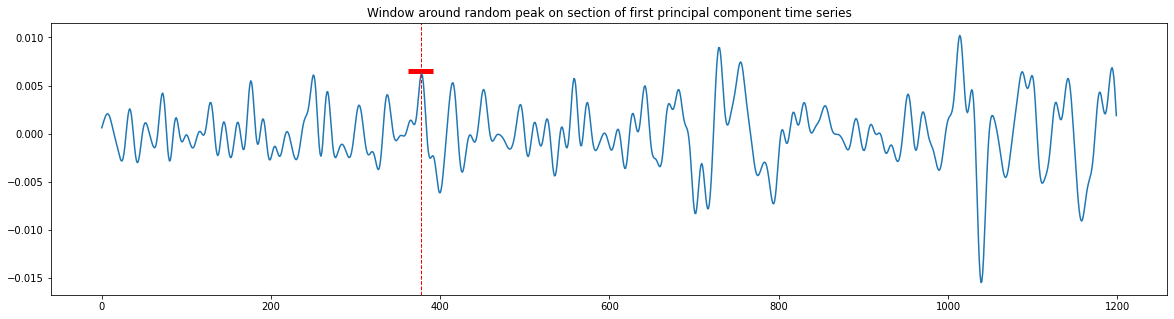

In [26]:
pca_results = pickle.load(open('demo_files/pca_rest_results.pkl', 'rb'))
comp0_ts = pca_results['U'][:,0]
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(comp0_ts[:1200])
ax.set_title('Window around random peak on section of first principal component time series')
ax.axvline(377, linestyle='--', c='r', linewidth=1)
ax.hlines(0.0065, xmin=362, xmax=392, linewidth=5, color='r')
plt.show()

In [27]:
%%HTML

<header>
    <h4>First Principal Component - Peak Average</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/pca_rest_component0.mp4"
        type="video/mp4">                                                       
</video>
<header>
    <h4>Quasiperiodic Pattern (QPP)</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/qpp_rest.mp4"
        type="video/mp4">                                                       
</video>

<font size='4'> Visual analysis of the peak-averaged first principal component and the QPP reveals striking consistency between these two patterns. However, it's clear that the QPP is picking up a much greater contrast between the task-positive and task-negative pattern. Specifically, the QPP has a longer lasting TP/TN contrast compared to a much more transient TP/TN contrast in the peak-averaged principal component movie. The most striking consistency is in the directions of propagation: peak amplitudes in the sensorimotor and superior parietal cortex propagate in two broad directions: downwards to the primary visual cortex, inferior parietal cortex, and Precuneus; forward to the lateral prefrontal cortex and posterior medial frontal cortex. In other words, the QPP ends with peak amplitudes of the DMN and primary visual cortex. We noted this propagation pattern earlier in the original discussion of the QPP (<b>Sec 1</b>). </font> 

# WORK IN PROGRESS

In [385]:
%%capture 
# ^ supress printing
group_data_orig, hdr, zero_mask, _ = load_data_and_stack(50, 'gifti', global_signal=0)

In [95]:
corr_mat = np.corrcoef(zscore(group_data_orig.T))

In [57]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from matplotlib.patches import Rectangle

In [58]:
svd = TruncatedSVD(n_components=200)
pcs = svd.fit_transform(zscore(group_data_orig).T)

In [63]:
gmm = GaussianMixture(n_components=2)
labels = gmm.fit_predict(zscore(pcs.T).T)

In [77]:
def plot_sorted_corr_mat(corr_mat, cluster_assignments, cmin=None, cmax=None):
	# Create sorting index from factor assignments
	sort_indx = np.argsort(cluster_assignments)
	sorted_vals = np.sort(cluster_assignments)
	# Sort Distance Matrix
	sortedmat = [[corr_mat[i][j] for j in sort_indx] for i in sort_indx]
	# Plot Distance Matrix
	fig, ax = plt.subplots(figsize=(10,7))
	c = plt.pcolormesh(sortedmat, cmap='RdBu_r', vmax=cmax, vmin=cmin)
	fig.colorbar(c, ax=ax)
	# Plot rectangular patches along diagnol to indicate factor assignments
	for i in np.unique(sorted_vals):
		ind = np.where(sorted_vals == i)
		mn = np.min(ind)
		mx = np.max(ind)
		sz=(mx-mn)+1
		rect = Rectangle((mn,mn), sz, sz ,linewidth=1,edgecolor='r',facecolor='none')
		ax.add_patch(rect)
	plt.show()


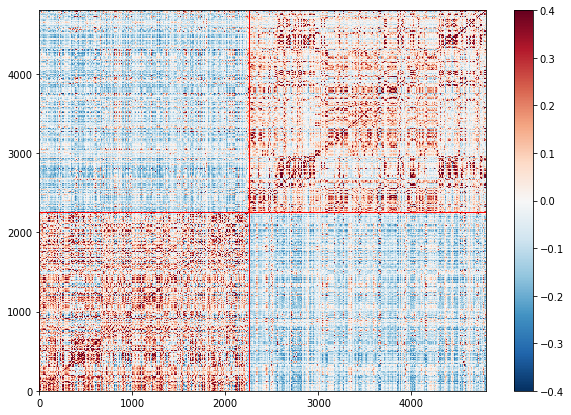

In [96]:
plot_sorted_corr_mat(corr_mat, labels, -0.4, 0.4)

In [377]:
from utils.utils import write_to_gifti
# write_to_gifti(labels.T[np.newaxis, :]+1, hdr, 'test_nogs', zero_mask)

In [397]:
cifti = load_cifti('mssa_recon_comp.dtseries.nii')
_, group_data, n_time = pull_cifti_data(cifti)
zero_mask = np.std(group_data, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
group_data = group_data[:, zero_mask].copy()

In [93]:
corr_mat_new = np.corrcoef(zscore(group_data.T))

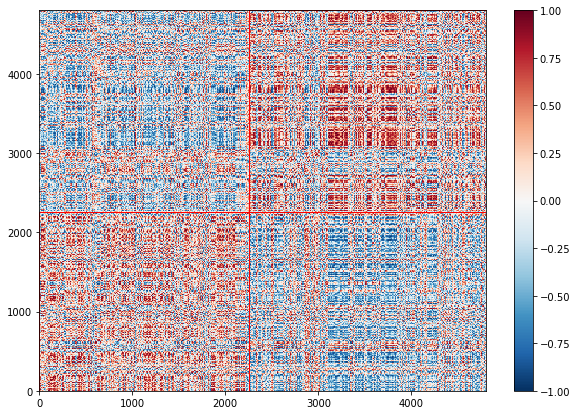

In [97]:
plot_sorted_corr_mat(corr_mat_new, labels, -1, 1)

In [398]:
from run_main_pca import pca
pca_results = pca(zscore(group_data), 5)

In [399]:
write_to_gifti(pca_results['Va'], hdr, 'test', zero_mask)

In [389]:
cifti = load_cifti('mssa_comp0.dtseries.nii')
_, cifti_ts, n_time = pull_cifti_data(cifti)

cifti = load_cifti('results/pca_peak_average_rest_0.dtseries.nii')
_, cifti_ts_pk_avg, n_time = pull_cifti_data(cifti)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

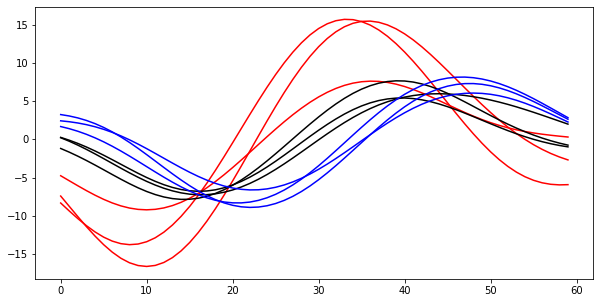

In [511]:
fig, ax = plt.subplots(figsize=(10,5))
begin = [658, 884, 1478]
transition = [1934, 1784, 1167]
end = [1226, 393, 1746]
ax.plot(cifti_ts[:, begin], label='Start', c='red')
ax.plot(cifti_ts[:, transition], label='Transition', c='black')
ax.plot(cifti_ts[:, end], label='End', c='blue')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

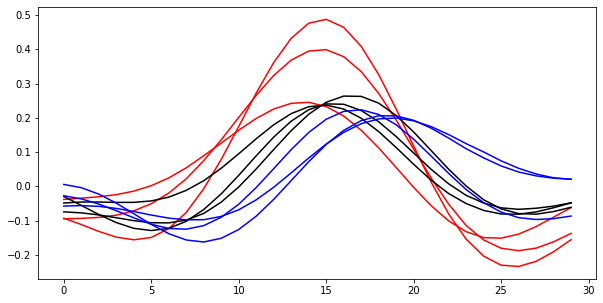

In [512]:
fig, ax = plt.subplots(figsize=(10,5))
begin = [658, 884, 1478]
transition = [1934, 1784, 1167]
end = [1226, 393, 1746]
ax.plot(cifti_ts_pk_avg[:, begin], label='Start', c='red')
ax.plot(cifti_ts_pk_avg[:, transition], label='Transition', c='black')
ax.plot(cifti_ts_pk_avg[:, end], label='End', c='blue')

In [25]:
std_noise = 0.05; # noise-to-signal ratio
n_per_shift = 50
ts_len = 2000  
tr = 0.72
phase_jitter=10
amplitude_jitter=0.5
phase_shift = 10
start = 50
ts_sampling=0.01
n_repeats=100
n_resample = np.int(ts_len*ts_sampling/tr)*n_repeats

static_region = range(0,10)
travel_region = range(10,50)

all_ts = np.zeros((50,50,n_resample))

indx = 0

for n in static_region:
    all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
    all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
    indx += 1

for i, n in enumerate(travel_region):
    all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
    all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
    start += phase_shift
    indx += 1

all_ts_2d = [(all_ts[i,j,:], (i,j)) for i in range(all_ts.shape[0]) for j in range(all_ts.shape[1])]
mat_2d = np.array([ts[0] for ts in all_ts_2d]).T

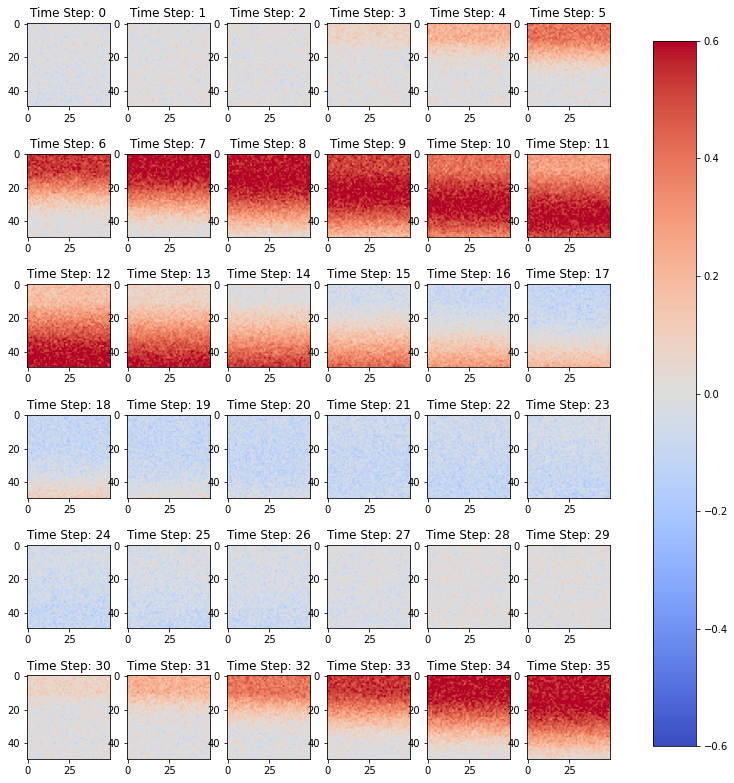

In [26]:
fig, ax = plt.subplots(6,6,figsize=(12,14))

for i, ax in enumerate(fig.axes):
    im = ax.imshow(all_ts[:,:,i], cmap='coolwarm', vmin=-0.6, vmax=0.6)
    ax.set_title(f'Time Step: {i}')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

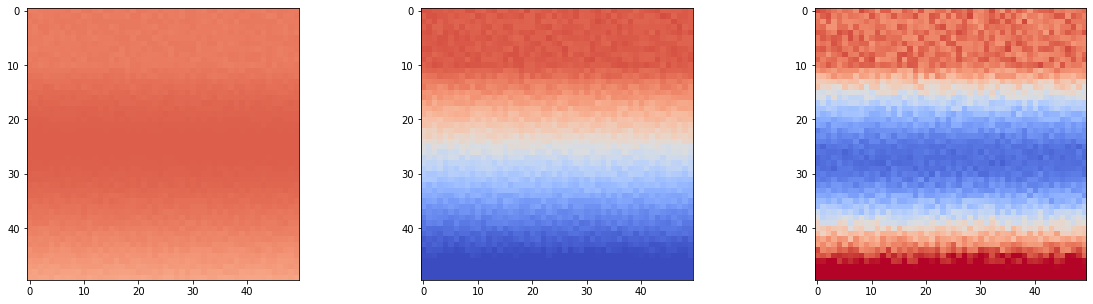

In [43]:
pca = PCA(n_components=5)
pca.fit(zscore(mat_2d))
fig, axs = plt.subplots(1,3, figsize=(20,5))
for n in range(3):
    axs[n].imshow(pca.components_[n,:].reshape(50,50), vmin=-0.03, vmax=0.03, cmap='coolwarm')
plt.show()

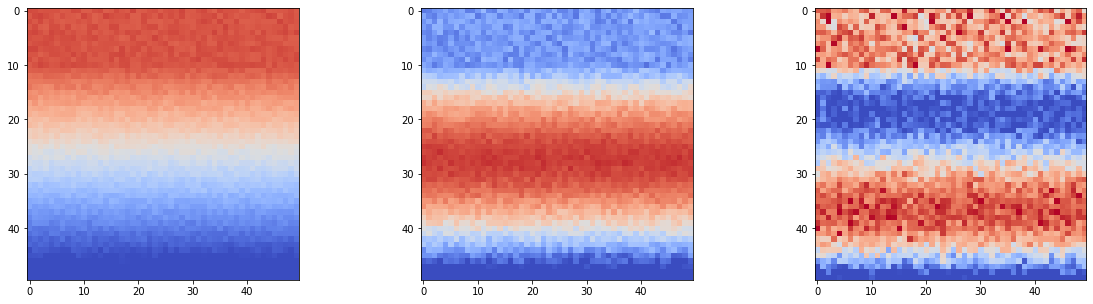

In [42]:
pca = PCA(n_components=5)
pca.fit(zscore(mat_2d.T).T)
fig, axs = plt.subplots(1,3, figsize=(20,5))
for n in range(3):
    axs[n].imshow(pca.components_[n,:].reshape(50,50), vmin=-0.03, vmax=0.03, cmap='coolwarm')
plt.show()

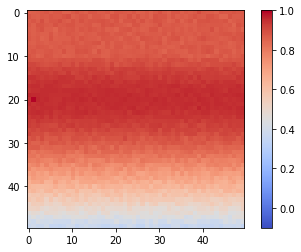

In [57]:
from sklearn.linear_model import LinearRegression
fc_map = []
for vertex_ts in mat_2d.T:
    lin_reg = LinearRegression()
    lin_reg.fit(mat_2d[:, 1001].reshape(-1, 1), 
                vertex_ts.reshape(-1, 1))
    fc_map.append(lin_reg.coef_[0][0])
fc_map = np.array(fc_map)
plt.imshow(fc_map.reshape(50,50), vmin=-0.1, vmax=1, cmap='coolwarm')
plt.colorbar()

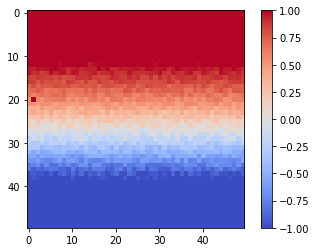

In [83]:
from sklearn.linear_model import LinearRegression
residual_ts_all = []
global_signal = mat_2d.mean(axis=1)
for vertex_ts in mat_2d.T:
        lin_reg = LinearRegression()
        lin_reg.fit(global_signal.reshape(-1, 1), 
                    vertex_ts.reshape(-1, 1))
        pred_ts = lin_reg.predict(global_signal.reshape(-1,1))
        residual_ts = vertex_ts.reshape(-1,1) - pred_ts
        residual_ts_all.append(residual_ts)
mat_2d_r = np.squeeze(np.array(residual_ts_all)).T

fc_map = []
for vertex_ts in mat_2d_r.T:
    lin_reg = LinearRegression()
    lin_reg.fit(mat_2d_r[:, 1001].reshape(-1, 1), 
                vertex_ts.reshape(-1, 1))
    fc_map.append(lin_reg.coef_[0][0])
fc_map = np.array(fc_map)
plt.imshow(fc_map.reshape(50,50), vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

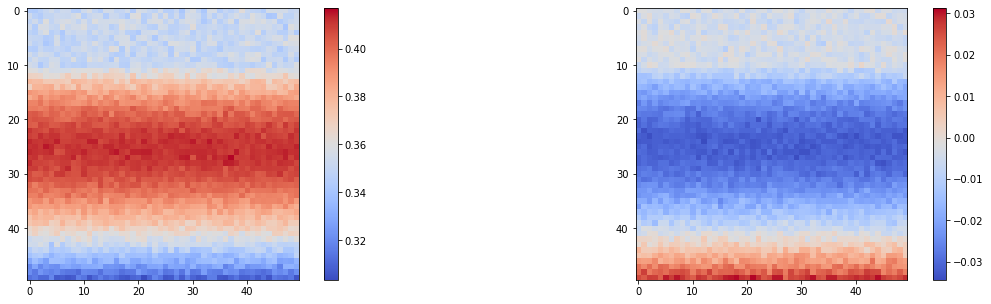

In [73]:
from run_cap_analysis import get_suprathreshold_maps, cluster_maps
selected_tps, selected_maps = get_suprathreshold_maps(mat_2d[:,1001], mat_2d, 85)
clus_centers, clus_labels = cluster_maps(mat_2d, False, 2)
clus_centers_norm, clus_labels_norm = cluster_maps(mat_2d, True, 2)

fig, axs = plt.subplots(1,2, figsize=(20,5))
for n in range(2):
    im = axs[n].imshow(clus_centers[n,:].reshape(50,50), cmap='coolwarm')
    fig.colorbar(im, ax=axs[n])
plt.show()


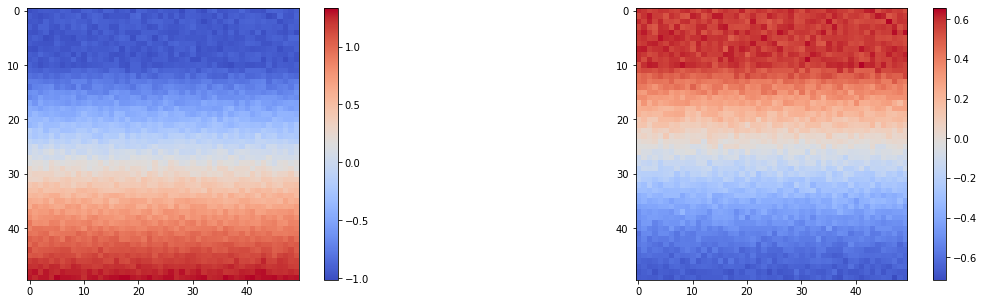

In [75]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
for n in range(2):
    im = axs[n].imshow(clus_centers_norm[n,:].reshape(50,50), cmap='coolwarm')
    fig.colorbar(im, ax=axs[n])
plt.show()

In [81]:
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

pca_scores = PCA(n_components=10).fit_transform(mat_2d)
dist = pairwise_distances(zscore(mat_2d), metric='euclidean')
dist_norm = pairwise_distances(zscore(zscore(mat_2d).T).T, metric='euclidean')

isomap = Isomap(metric='precomputed')
isomap_norm = Isomap(metric='precomputed')

isomap.fit(dist)
isomap_norm.fit(dist_norm)

Isomap(metric='precomputed')

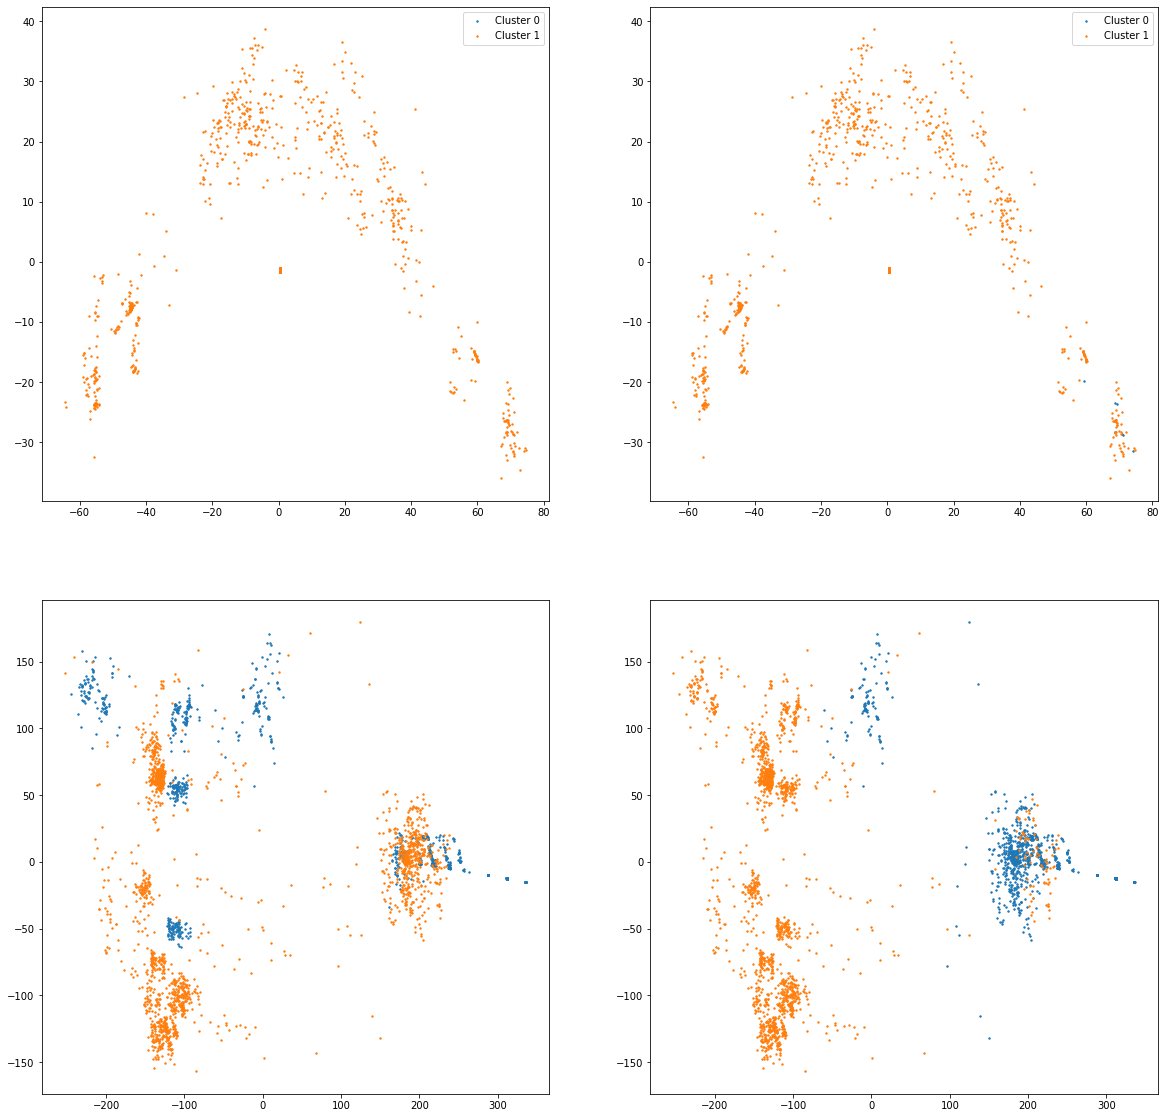

In [82]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
comps = isomap.embedding_
for i in np.unique(clus_labels):
# for i in [0,1]:
    clus_indx = np.where(clus_labels == i)[0]
    ax[0,0].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2, label=f'Cluster {i}')
    ax[0,0].legend()

for i in np.unique(clus_labels_norm):
    clus_indx = np.where(clus_labels_norm == i)[0]
    ax[0,1].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2, label=f'Cluster {i}')
    ax[0,1].legend()
    
comps = isomap_norm.embedding_
for i in np.unique(clus_labels):
# for i in [0,1]:
    clus_indx = np.where(clus_labels == i)[0]
    ax[1,0].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2)

for i in np.unique(clus_labels_norm):
    clus_indx = np.where(clus_labels_norm == i)[0]
    ax[1,1].scatter(comps[clus_indx, 0], comps[clus_indx, 1], s=2)    

plt.show()

# <b>Appendix</b>

## Appendix A - Principal Component Rotation, Simple Structure and Independent Component Analysis

<font size='4'>In this appendix, we illustrate the concept of rotation of principal component axes towards simple structure. Various forms of rotation exist, but all rotate the original component loadings towards what has been called simple structure - i.e. each vertex loads strongly on only one eigenvector. Thus, the original principal component solution is modified into more of a clustering solution. We illustrate an orthogonal rotation of principal component weights toward simple structure below:

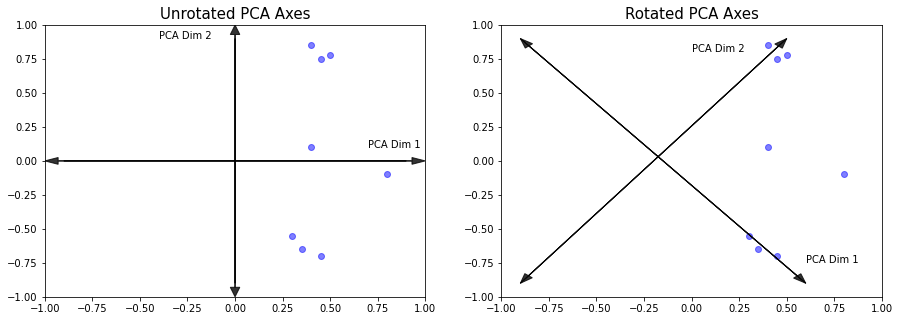

In [175]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
vertices = [[0.5, 0.78], [0.4, 0.85], [0.45, 0.75], [0.3, -0.55], [0.35, -0.65], [0.45, -0.7], [0.8, -0.1], [0.4, 0.1]]
for vertex in vertices:
    ax[0].scatter(vertex[0], vertex[1], color='blue', alpha=0.5)
    ax[1].scatter(vertex[0], vertex[1], color='blue', alpha=0.5)
ax[0].set_xlim([-1,1]); ax[1].set_xlim([-1,1])
ax[0].set_ylim([-1,1]); ax[1].set_ylim([-1,1])
ax[0].arrow(-0.9, 0, 1.9, 0, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[0].arrow(0.9, 0, -1.9, 0, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[0].arrow(0, -0.9, 0, 1.9, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[0].arrow(0, 0.9, 0, -1.9, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[1].arrow(-0.9, -0.9, 1.4, 1.8, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[1].arrow(0.5, 0.9, -1.4, -1.8, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[1].arrow(-0.9, 0.9, 1.5, -1.8, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[1].arrow(0.6, -0.9, -1.5, 1.8, color='black', alpha=0.8, head_length = 0.07, head_width = 0.05, length_includes_head = True)
ax[0].text(0.7, 0.1, 'PCA Dim 1'); ax[1].text(0.6, -0.75, 'PCA Dim 1')
ax[0].text(-0.4, 0.9, 'PCA Dim 2'); ax[1].text(0, 0.8, 'PCA Dim 2')
ax[0].set_title('Unrotated PCA Axes', fontsize=15)
ax[1].set_title('Rotated PCA Axes', fontsize=15)
plt.show()

<font size='4'>In this toy example, we fit a two component PCA solution to time series from eight vertices. Displayed above are the eights vertices (plotted in blue) plotted in a two-dimensional component space. The distance from the axis to each vertex represents the correlation between the vertex and the principal component (i.e. the loading of that vertex on the component), the further the distance, the smaller the correlation. Notice that six of the eight vertices form two clusters of three vertices -  illustrating groups of vertices with strongly correlated time series. The first component loadings (the component that explains the maximum variability in the data) do not reveal the cluster structure among the vertices; nor does the second component. The goal of rotation is to rotate these factors towards more sparse component loadings - simple structure - that are more physically meaningful. The rotation displayed above is an orthogonal rotation - it keeps the spatial orthogonality of the component weights, but drops the temporal uncorrelatedness among the PCA component time series.</font>

## Appendix B - Global Signal Regression and Lag Projections

<font size='4'>The lag projection from our data partially resembles the across-subject average lag projection observed in Raut et al. (2019), but our lag projection is nearly twice as long (~2 sec compared to ~1 sec).</font>

In [31]:
ipyplot.plot_images(['demo_files/lag_projection.png'], 
                    ['Lag Projection'], img_width=500)

<font size='4'>However, our data differs in one important respect: Raut el. (2019) performed a global signal regression as preprocessing step. In fact, when we regress out the global signal of our data, we see the following lag projection:  </font> 

In [32]:
ipyplot.plot_images(['demo_files/lag_projection_gs.png'], 
                    ['Lag Projection - Global Signal Regressed'], img_width=500)

<font size='4'> The lag projection of the global signal regressed data closely matches the spatial distribution time-lags observed in Raut et al. (2019): activation beginning in superior medial prefrontal cortex and ending in Default Mode Network and visual cortex. In addition, the length of the lag projection is now 1 sec (cut in time by half from non-globally regressed data), matching Raut et al. (2019). Comparing the global signal regressed and non-regressed lag projections, it seems that the latter half of the non-regressed lag projection is still intact after global signal regression: activation ending in the Default Mode Network (but the primary visual cortex seems to be one of the starting regions now). The early activation in the sensorimotor cortex seems to be 'pushed' forward in time - moving anteriorly into the prefrontal cortex. It's difficult to say exactly what the global signal regression is doing here, but one might speculate that it is pushing the temporal structure of the global signal propagation event 'forward' in time, which would account for the shortening of the length of the total event.  </font>  